## Script info

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""   Analyse simulations   -- Version 1.0
Last edit:  2023/08/29
Authors:    Leone, Riccardo (RL)
Notes:      - Analyse all the models
            - Release notes:
                * Initial commit
To do:      - 
Comments:   

Sources: 
"""

'   Analyse simulations   -- Version 1.0\nLast edit:  2023/08/29\nAuthors:    Leone, Riccardo (RL)\nNotes:      - Analyse all the models\n            - Release notes:\n                * Initial commit\nTo do:      - \nComments:   \n\nSources: \n'

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from petTOAD_setup_log import *
from statannotations.Annotator import Annotator
from sklearn.linear_model import LinearRegression

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


## Directories

In [3]:
SIM_DIR = RES_DIR / "final_simulations_log_more_detailed"
A_DIR = SIM_DIR / "a-weight_ws_-0.05-0.0_bs_-0.025-0.0"
A_RAND_DIR = SIM_DIR / "a-weight_ws_-0.05-0.0_bs_-0.025-0.0_random"
G_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0"
G_RAND_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0_random"
SC_DIR = SIM_DIR / "sc_disconn"
HET_DIR = SIM_DIR / "heterogeneous_ws_-0.05-0.0_bs_-0.025-0.0"
HET_RAND_DIR = SIM_DIR / "heterogeneous_ws_-0.05-0.0_bs_-0.025-0.0_random"
GLOB_A_DIR = SIM_DIR / "homogeneous_a_global_model"
GLOB_G_DIR = SIM_DIR / "G-weight_global_model"
FIG_DIR = RES_DIR / "Figures"
EXT_RES_DIR = "/mnt/e/petTOAD/results/LQT"
if not Path.exists(FIG_DIR):
    Path.mkdir(FIG_DIR)
MCI_DIR = RES_DIR / "model_simulations" / "MCI_noWMH"

## Functions

In [4]:
def annotate_star(tbl):
    """
    This function is just to plot an asterisk at the best heatmap value for better recognition.
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star


def find_max_b_w_tbl(tbl):
    """
    This function finds the w and b that are associated with the star (best value) in the heatmap of group comparisons
    """
    max_value = tbl.values.max()
    mask = tbl == max_value
    column_names = tbl.columns[mask.any(axis=0)]
    column_floats = [float(col) for col in column_names]
    row_names = tbl.index[mask.any(axis=1)]
    row_floats = [float(row) for row in row_names]
    return row_floats[0], column_floats[0]


def get_best_dfs(big_df, fc_name, phfcd_name, comp_score_name, wmh_dict):
    big_df["comp_score"] = big_df["fc_pearson"] + 1 * big_df["phfcd_ks"]
    # Get the best model fits for fc, phfcd for each subject and create one single df (skip fcd for now)
    res_df_best = pd.DataFrame(
        {
            fc_name: big_df.groupby(["PTID"])[fc_name].max(),
            phfcd_name: big_df.groupby(["PTID"])[phfcd_name].max(),
            comp_score_name: big_df.groupby(["PTID"])[comp_score_name].max(),
        }
    ).reset_index()

    res_df_best["wmh_load"] = [wmh_dict[subj] for subj in res_df_best["PTID"]]
    # This df is to check what are the best w, b in case of the best fc, best phfcd and best glob score
    # First we group by each patient and get the max fc pearson for each
    # Then we merge this df (with the name of pt and max fc) with the df containing also b and w
    # so we have: max(FC), b, w for each patient etc.
    max_fc_vals = big_df.groupby(["PTID"])[fc_name].max().reset_index()
    merged_df_max_fc = pd.merge(big_df, max_fc_vals, on=["PTID", fc_name])
    # We do the same for 1-phFCD
    max_phfcd_vals = big_df.groupby(["PTID"])[phfcd_name].max().reset_index()
    merged_df_max_phfcd = pd.merge(big_df, max_phfcd_vals, on=["PTID", phfcd_name])
    # We do the same for GFS
    max_comp_score_vals = big_df.groupby(["PTID"])[comp_score_name].max().reset_index()
    merged_df_max_comp_score = pd.merge(
        big_df, max_comp_score_vals, on=["PTID", comp_score_name]
    )

    return merged_df_max_fc, merged_df_max_phfcd, merged_df_max_comp_score


def plot_parm_best_wmh_relationship(parm, df_max_comp_score):
    """
    This function plots the relationship between the best achieved FC and (1-phFCD) and WMH (normalized) in the parameter space that was explored
    """
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    # Values that give the best FC
    sns.regplot(
        ax=axs[0, 1],
        data=df_max_comp_score[df_max_comp_score["PTID"].isin(CN_WMH)],
        x="wmh_load",
        y=parm,
        label="CU WMH",
    )
    sns.regplot(
        ax=axs[0, 1],
        data=df_max_comp_score[df_max_comp_score["PTID"].isin(MCI_WMH)],
        x="wmh_load",
        y=parm,
        label="MCI WMH",
    )
    fig.legend()
    fig.tight_layout()


def create_pivot_tables(df_res):
    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(
        df_res, values="fc_pearson", index="b", columns="w"
    ).astype(float)
    # Skip fcd for now
    # table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(
        df_res, values="phfcd_ks", index="b", columns="w"
    ).astype(float)
    # Create a composite score by summing up the single model fits so to choose when FC and phFCD have different "best" b-w combinations
    table_comp_score = table_fc + 1 * table_phfcd
    return table_fc, table_phfcd, table_comp_score


def plot_save_heatmaps(table_fc, table_phfcd, table_comp_score, random):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """
    # Create Heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ax=axs[0],
        data=table_fc,
        annot=annotate_star(table_fc),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[0].set_title(f"FC", fontsize=9)

    sns.heatmap(
        ax=axs[1],
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[1].set_title(f"1 - phFCD", fontsize=9)
    sns.heatmap(
        ax=axs[2],
        data=table_comp_score,
        annot=annotate_star(table_comp_score),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[2].set_title(f"GFS", fontsize=9)
    if not random:
        savename = f"weights_and_bias_heatmap.png"
        fig.suptitle("Random = False")
    else:
        savename = f"weights_and_bias_heatmap_random.png"
        fig.suptitle("Random = True")
    fig.tight_layout()
    plt.savefig(FIG_DIR / savename)


def perform_group_analyses(df_petTOAD, big_df, random):
    """
    This function allow us to select the grouping classification (Fazekas 1, Fazekas 2 or all) as the 'group'variable and then it selects
    only CN and MCI with WMH based on the chosen classification (since we are not interested for this type of model in patients without WMH).
    Then, calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (CN or MCI) according to the chosen grouping.

    Args:
        df_petTOAD:
        big_df:
        group:
        random:

    Returns:
        The b and ws associated with
    """
    CN_WMH = df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["PTID"]
    MCI_WMH = df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["PTID"]

    CN_wmh_df = big_df[big_df["PTID"].isin(CN_WMH)]
    CN_wmh_grouped = CN_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    tbl_fc_CN_wmh, tbl_phfcd_CN_wmh, tbl_comp_score_CN_wmh = create_pivot_tables(
        CN_wmh_grouped
    )
    plot_save_heatmaps(
        tbl_fc_CN_wmh,
        tbl_phfcd_CN_wmh,
        tbl_comp_score_CN_wmh,
        random,
    )

    mci_wmh_df = big_df[big_df["PTID"].isin(MCI_WMH)]
    mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    tbl_fc_mci_wmh, tbl_phfcd_mci_wmh, tbl_comp_score_mci_wmh = create_pivot_tables(
        mci_wmh_grouped
    )
    plot_save_heatmaps(
        tbl_fc_mci_wmh,
        tbl_phfcd_mci_wmh,
        tbl_comp_score_mci_wmh,
        random,
    )

    b_CN_wmh, w_CN_wmh = find_max_b_w_tbl(tbl_comp_score_CN_wmh)
    b_mci_wmh, w_mci_wmh = find_max_b_w_tbl(tbl_comp_score_mci_wmh)

    print("The best parameters found for these heatmaps are:")
    print(f"b = {b_CN_wmh}, w = {w_CN_wmh}, for CN with WMH")
    print(f"b = {b_mci_wmh}, w = {w_mci_wmh}, for MCI with WMH")

    return b_CN_wmh, w_CN_wmh, b_mci_wmh, w_mci_wmh


def perform_big_group_analyses(df_petTOAD, big_df, random):
    """
    This function allow us to select the grouping classification (Fazekas 1, Fazekas 2 or all) as the 'group'variable and then it selects
    only CN and MCI with WMH based on the chosen classification (since we are not interested for this type of model in patients without WMH).
    Then, calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (CN or MCI) according to the chosen grouping.

    Args:
        df_petTOAD:
        big_df:
        group:
        random:

    Returns:
        The b and ws associated with
    """
    WMH = df_petTOAD[df_petTOAD["WMH_bin"] == "WMH"]["PTID"]

    wmh_df = big_df[big_df["PTID"].isin(WMH)]
    wmh_grouped = wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    tbl_fc_wmh, tbl_phfcd_wmh, tbl_comp_score_wmh = create_pivot_tables(
        wmh_grouped
    )
    plot_save_heatmaps(
        tbl_fc_wmh,
        tbl_phfcd_wmh,
        tbl_comp_score_wmh,
        random,
    )

    b_wmh, w_wmh = find_max_b_w_tbl(tbl_comp_score_wmh)

    print("The best parameters found for these heatmaps are:")
    print(f"b = {b_wmh}, w = {w_wmh}, for CN with WMH")

    return b_wmh, w_wmh


def select_b_w_combo(df_boxplot_long, w1, b1, w2, b2, groupname1, groupname2):
    compare_df1 = df_boxplot_long[
        (df_boxplot_long["w"] == w1) & (df_boxplot_long["b"] == b1)
    ]
    compare_df1 = compare_df1[compare_df1["group"] == groupname1]
    compare_df2 = df_boxplot_long[
        (df_boxplot_long["w"] == w2) & (df_boxplot_long["b"] == b2)
    ]
    compare_df2 = compare_df2[compare_df2["group"] == groupname2]
    joined_compare_df = pd.concat([compare_df1, compare_df2])
    return compare_df1, compare_df2, joined_compare_df


def create_df_boxplot(df_big, best_fit_b, best_fit_w, diagnosis_group_wmh, model_type):
    """
    This function starts from the big database obtained from the model simulation (e.g., a-weighted homogenous, G-weighted homgoeneous, heterogeneous, etc.) and creates
    a smaller dataset with only the observable variables obtained with the best b and w combination as before. It is useful to then create a long df for plotting.
    """
    df = pd.DataFrame()
    df["PTID"] = df_big[
        (df_big["b"] == best_fit_b)
        & (df_big["w"] == best_fit_w)
        & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)
    ]["PTID"]
    df["fc_pearson"] = df_big[
        (df_big["b"] == best_fit_b)
        & (df_big["w"] == best_fit_w)
        & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)
    ]["fc_pearson"]
    df["phfcd_ks"] = df_big[
        (df_big["b"] == best_fit_b)
        & (df_big["w"] == best_fit_w)
        & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)
    ]["phfcd_ks"]
    df["comp_score"] = df["fc_pearson"] + 1 * df["phfcd_ks"]
    df["Model_type"] = [f"{model_type}" for _ in range(len(df))]
    return df

def create_df_boxplot_wmh(df_big, best_fit_b, best_fit_w, model_type):
    """
    This function starts from the big database obtained from the model simulation (e.g., a-weighted homogenous, G-weighted homgoeneous, heterogeneous, etc.) and creates
    a smaller dataset with only the observable variables obtained with the best b and w combination as before. It is useful to then create a long df for plotting.
    """
    df = pd.DataFrame()
    df["PTID"] = df_big[
        (df_big["b"] == best_fit_b)
        & (df_big["w"] == best_fit_w)
        & (df_big["WMH_bin"] == "WMH")
    ]["PTID"]
    df["fc_pearson"] = df_big[
        (df_big["b"] == best_fit_b)
        & (df_big["w"] == best_fit_w)
        & (df_big["WMH_bin"] == "WMH")
    ]["fc_pearson"]
    df["phfcd_ks"] = df_big[
        (df_big["b"] == best_fit_b)
        & (df_big["w"] == best_fit_w)
        & (df_big["WMH_bin"] == "WMH")
    ]["phfcd_ks"]
    df["comp_score"] = df["fc_pearson"] + 1 * df["phfcd_ks"]
    df["Model_type"] = [f"{model_type}" for _ in range(len(df))]
    return df


def plot_obs(df, obs, ax, eq=False):
    """
    This function plots the annotations for statistical comparisons between groups
    """
    order = ["Base", "Homo.", "Hetero.", "G-weight", "Disconn."]
    if not eq:
        # Choose the combinations that you want to test..
        pairs = [
            ("Base", "Homo."),
            ("Base", "Hetero."),
            ("Base", "G-weight"),
            ("Base", "Disconn."),
            ("Homo.", "Hetero."),
            ("Homo.", "G-weight"),
            ("Hetero.", "G-weight"),
        ]
    else:
        pairs = [
            ("Base", "Hetero."),
            ("Base", "G-weight"),
            ("Base", "Disconn."),
            ("Hetero.", "G-weight"),
        ]
    f = sns.boxplot(data=df, x="Model_type", y=obs, ax=ax)
    annotator = Annotator(f, pairs, data=df, x="Model_type", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(test="Wilcoxon", text_format="star", loc="inside", verbose=1)
    annotator.apply_and_annotate()
    plt.xticks([0, 1, 2, 3, 4], order)
    plt.xlabel("Model type")


def plot_random_comparison(df, obs, axs):
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model
    """
    pairs = [
        (("Homo.", "Random"), ("Homo.", "Not Random")),
        (("Hetero.", "Random"), ("Hetero.", "Not Random")),
        (("G-weight", "Random"), ("G-weight", "Not Random")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "Model_type",
            "y": f"{obs}",
            "hue": "Random",
            "hue_order": ["Random", "Not Random"],
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Wilcoxon",
        },  # this takes what normally goes into ant.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        "ax": axs,
    }

    # df["Model_type"] = df["Model_type"].str.replace("Homo. rand.", "Homo.")
    # df["Model_type"] = df["Model_type"].str.replace("Hetero. rand.", "Hetero.")
    # df["Model_type"] = df["Model_type"].str.replace("G rand.", "G-weight")


    df["Model_type"] = np.where(df["Model_type"] == "Homo. rand.", "Homo.", df["Model_type"])
    df["Model_type"] = np.where(df["Model_type"] == "Hetero. rand.", "Hetero." , df["Model_type"])
    df["Model_type"] = np.where(df["Model_type"] == "G rand.", "G-weight", df["Model_type"])

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    plt.close()


def plot_CN_mci_comparison(obs, df_compare_groups):  # (obs, axs) if you want subplots
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model
    """
    df_compare_groups["group"] = df_compare_groups["group"].str.replace(
        "CN", "CU"
    )  # Change to CU so that the label is already ok
    pairs = [
        (("Base", "CU WMH"), ("Base", "MCI WMH")),
        (("Homo.", "CU WMH"), ("Homo.", "MCI WMH")),
        (("Hetero.", "CU WMH"), ("Hetero.", "MCI WMH")),
        (("G-weight", "CU WMH"), ("G-weight", "MCI WMH")),
        (("Disconn.", "CU WMH"), ("Disconn.", "MCI WMH")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "Model_type",
            "y": f"{obs}",
            "hue": "group",
            # "hue_order": ["CN WMH", "MCI WMH"],
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Mann-Whitney"
        },  # this takes what normally goes into ant.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        # "ax": axs,
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df_compare_groups, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    # plt.close()


def create_df_max_rand(df_max, df_rand_big, model_type):
    df_max_rand = pd.DataFrame()

    for row in df_max.iterrows():
        ptid = row[1]["PTID"]
        w = row[1]["w"]
        b = row[1]["b"]
        df_max_rand = pd.concat(
            [
                df_max_rand,
                df_rand_big[
                    (df_rand_big["PTID"] == ptid)
                    & (df_rand_big["w"] == w)
                    & (df_rand_big["b"] == b)
                ],
            ]
        )
        df_max_rand["Model_type"] = model_type
    return df_max_rand


def plot_wmh_a_G_relationship(
    df_max_comp_score_a_cn_mmse,
    df_max_comp_score_a_mci_mmse,
    df_max_comp_score_G_cn_mmse,
    df_max_comp_score_G_mci_mmse,
):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    # Plot the linear regression
    sns.regplot(
        ax=axs[0],
        data=df_max_comp_score_a_cn_mmse,
        x="wmh_load",
        y="a",
        label="CU WMH",
    )
    sns.regplot(
        ax=axs[0],
        data=df_max_comp_score_a_mci_mmse,
        x="wmh_load",
        y="a",
        label="MCI WMH",
    )
    sns.regplot(
        ax=axs[1],
        data=df_max_comp_score_G_cn_mmse,
        x="wmh_load",
        y="G",
        label="CU WMH",
    )
    sns.regplot(
        ax=axs[1],
        data=df_max_comp_score_G_mci_mmse,
        x="wmh_load",
        y="G",
        label="MCI WMH",
    )

    axs[0].set_xlabel("Normalized WMH volume")
    axs[1].set_xlabel("Normalized WMH volume")
    axs[0].legend()
    axs[1].legend()
    axs = axs.flat
    for n, ax in enumerate(axs):
        ax.text(
            -0.1,
            1.1,
            string.ascii_uppercase[n],
            transform=ax.transAxes,
            size=13,
            weight="bold",
        )
    fig.tight_layout()
    plt.savefig(FIG_DIR / "wmh_a_G_relationship.png")

## Prepare data

In [5]:
# Not all simulations are done, if we get the names of patients from the sc_disconn, these are the ones with all models completed
import glob
def find_completed_subj(DIR):
    list_completed_pts = []
    for file in glob.glob(f"{str(DIR)}/*.csv"):
        list_completed_pts.append(file.split("/")[-1].split("_")[0].split("-")[1])
    return list_completed_pts

list_completed = find_completed_subj(HET_RAND_DIR)


In [7]:
# Load wmh dictionary
wmh_dict = get_wmh_load_homogeneous(subjs_to_sim)
# Create overall dfs for each model and populate them with single subject results
df_a_big = pd.DataFrame()
df_a_rand_big = pd.DataFrame()
df_sc_big = pd.DataFrame()
df_G_big = pd.DataFrame()
df_G_rand_big = pd.DataFrame()
df_het_big = pd.DataFrame()
df_het_rand_big = pd.DataFrame()

# We loop through every subject
for subj in list_completed: #subjs_to_sim
    # we read the csv of saved results for each subject for all models
    df_a = pd.read_csv(
        A_DIR / f"sub-{subj}_df_results_homogeneous_a-weight.csv", index_col=0
    )
    df_a_rand = pd.read_csv(
        A_RAND_DIR / f"sub-{subj}_df_results_homogeneous_a-weight.csv",
        index_col=0,
    )
    df_het = pd.read_csv(
        HET_DIR / f"sub-{subj}_df_results_heterogeneous.csv",
        index_col=0,
    )
    df_het_rand = pd.read_csv(
        HET_RAND_DIR / f"sub-{subj}_df_results_heterogeneous.csv",
        index_col=0,
    )
    df_G = pd.read_csv(
        G_DIR / f"sub-{subj}_df_results_homogeneous_G-weight.csv", index_col=0
    )
    df_G_rand = pd.read_csv(
        G_RAND_DIR / f"sub-{subj}_df_results_homogeneous_G-weight.csv", index_col=0
    )
    df_sc = pd.read_csv(SC_DIR / f"sub-{subj}_df_results_disconn.csv", index_col=0)

    # Set the PTID column == to this subject
    df_a["PTID"] = subj
    df_a_rand["PTID"] = subj
    df_het["PTID"] = subj
    df_het_rand["PTID"] = subj
    df_G["PTID"] = subj
    df_G_rand["PTID"] = subj
    df_sc["PTID"] = subj

    # Get the wmh load for this subject
    df_a["wmh_load"] = wmh_dict[subj]
    df_G["wmh_load"] = wmh_dict[subj]

    # we concatenate results of all subjects and create model-specific datasets with all patients
    df_a_big = pd.concat([df_a_big, df_a], ignore_index=True)
    df_a_rand_big = pd.concat([df_a_rand_big, df_a_rand], ignore_index=True)
    df_het_big = pd.concat([df_het_big, df_het], ignore_index=True)
    df_het_rand_big = pd.concat([df_het_rand_big, df_het_rand], ignore_index=True)
    df_G_big = pd.concat([df_G_big, df_G], ignore_index=True)
    df_G_rand_big = pd.concat([df_G_rand_big, df_G_rand], ignore_index=True)
    df_sc_big = pd.concat([df_sc_big, df_sc], ignore_index=True)

# The baseline databases is with a = -0.02 and G = 1.9 == homogeneous a-weight database when b and w = 0!
df_base = df_a_big[(df_a_big["w"] == 0) & (df_a_big["b"] == 0)].copy()
df_base["phfcd_ks"] = 1 - df_base["phfcd_ks"]
# Then, we convert phfcd to 1-phfcd so to have higher numbers = better fits
df_a_big["phfcd_ks"] = 1 - df_a_big["phfcd_ks"]
df_a_rand_big["phfcd_ks"] = 1 - df_a_rand_big["phfcd_ks"]
df_het_big["phfcd_ks"] = 1 - df_het_big["phfcd_ks"]
df_het_rand_big["phfcd_ks"] = 1 - df_het_rand_big["phfcd_ks"]
df_G_big["phfcd_ks"] = 1 - df_G_big["phfcd_ks"]
df_G_rand_big["phfcd_ks"] = 1 - df_G_rand_big["phfcd_ks"]
df_sc_big["phfcd_ks"] = 1 - df_sc_big["phfcd_ks"]

# Make sure that we didn't mistakenly simulate any positive weights, in case exclude them
df_a_big = df_a_big[(df_a_big["b"] <= 0) & (df_a_big["w"] <= 0)].copy()
df_a_rand_big = df_a_rand_big[
    (df_a_rand_big["b"] <= 0) & (df_a_rand_big["w"] <= 0)
].copy()
df_het_big = df_het_big[(df_het_big["b"] <= 0) & (df_het_big["w"] <= 0)].copy()
df_het_rand_big = df_het_rand_big[
    (df_het_rand_big["b"] <= 0) & (df_het_rand_big["w"] <= 0)
].copy()
df_G_big = df_G_big[(df_G_big["b"] <= 0) & (df_G_big["w"] <= 0)].copy()
df_G_rand_big = df_G_rand_big[
    (df_G_rand_big["b"] <= 0) & (df_G_rand_big["w"] <= 0)
].copy()

# Load the clinical dataframe with the groupings
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv")
df_petTOAD_pre["PTID"] = df_petTOAD_pre["PTID"].str.replace("_", "")
df_petTOAD_pre = df_petTOAD_pre.rename(
    columns={"Group_bin_Fazekas": "Group_Fazekas_2.0"}
)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_Fazekas_2.0"].str.contains("no_WMH"), "no_WMH", "WMH"
)
df_petTOAD = df_petTOAD_pre.copy() #df_petTOAD_pre[df_petTOAD_pre["WMH_load_subj_space"] < 80000]


# Prepare databases with the maximum values for each type of model
df_max_fc_a, df_max_phfcd_a, df_max_comp_score_a = get_best_dfs(
    df_a_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict
)
df_max_fc_a_rand, df_max_phfcd_a_rand, df_max_comp_score_a_rand = get_best_dfs(
    df_a_rand_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict
)
df_max_fc_hetero, df_max_phfcd_hetero, df_max_comp_score_hetero = get_best_dfs(
    df_het_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict
)
(
    df_max_fc_hetero_rand,
    df_max_phfcd_hetero_rand,
    df_max_comp_score_hetero_rand,
) = get_best_dfs(df_het_rand_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict)
df_max_fc_G, df_max_phfcd_G, df_max_comp_score_G = get_best_dfs(
    df_G_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict
)
df_max_fc_G_rand, df_max_phfcd_G_rand, df_max_comp_score_G_rand = get_best_dfs(
    df_G_rand_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict
)
df_max_fc_sc, df_max_phfcd_sc, df_max_comp_score_sc = get_best_dfs(
    df_sc_big, "fc_pearson", "phfcd_ks", "comp_score", wmh_dict
)

In [ ]:
# assert (
#     df_a_big["PTID"].unique().shape[0]
#     & df_a_rand_big["PTID"].unique().shape[0]
#     & df_sc_big["PTID"].unique().shape[0]
#     & df_G_big["PTID"].unique().shape[0]
#     & df_G_rand_big["PTID"].unique().shape[0]
#     & df_het_big["PTID"].unique().shape[0]
#     & df_het_rand_big["PTID"].unique().shape[0]
#     & df_base["PTID"].unique().shape[0]
# ) == len(subjs_to_sim), "Something went wrong with loading"

### Prepare dfs for boxplots

The best parameters found for these heatmaps are:
b = 0.0, w = -0.008, for CN with WMH
b = 0.0, w = -0.013, for MCI with WMH
The best parameters found for these heatmaps are:
b = 0.0, w = -0.65, for CN with WMH
b = -0.1, w = -0.35, for MCI with WMH
The best parameters found for these heatmaps are:
b = -0.005, w = 0.0, for CN with WMH
b = 0.0, w = -0.018, for MCI with WMH


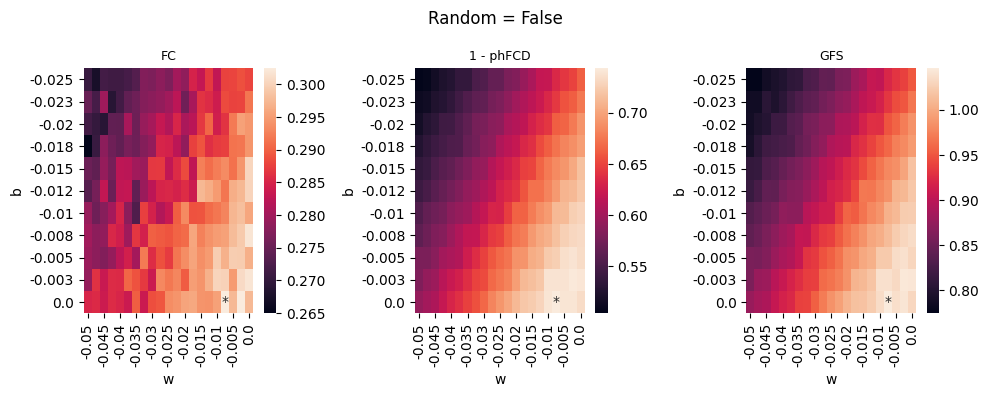

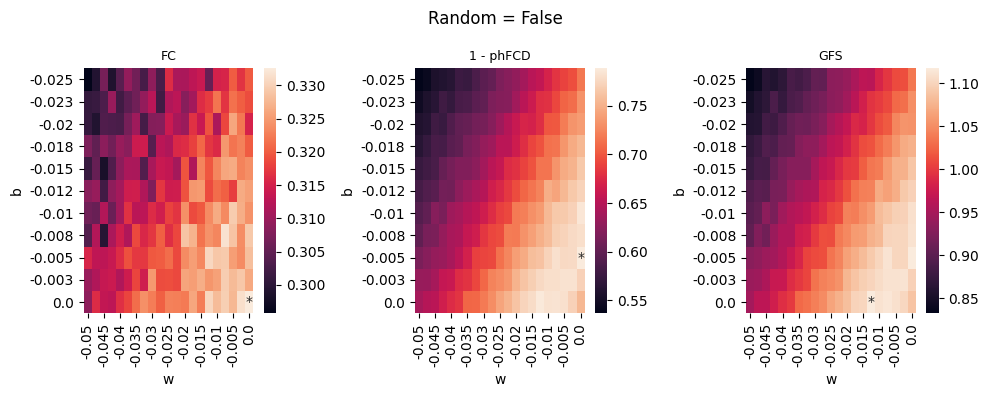

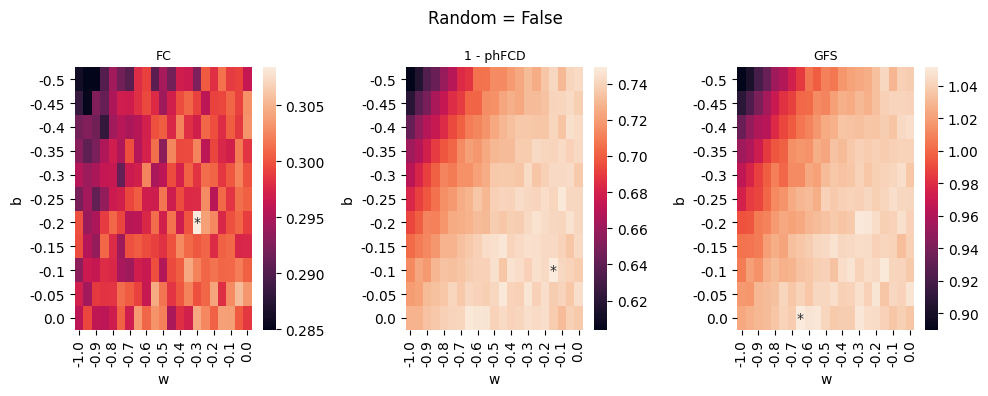

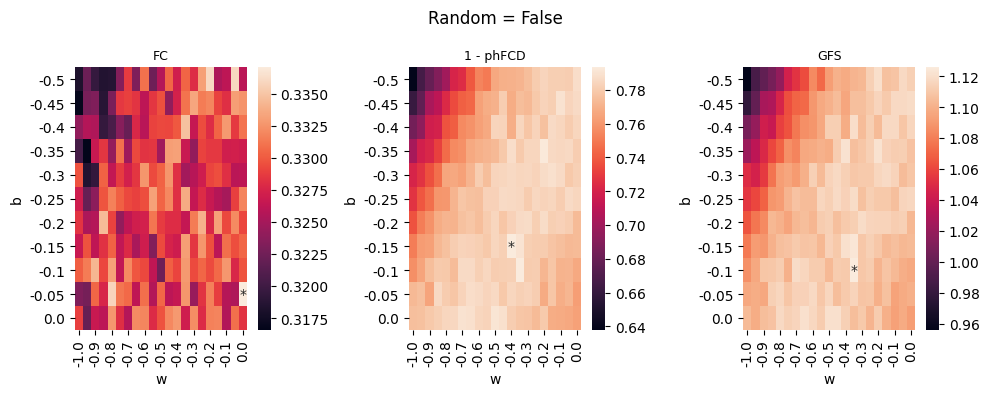

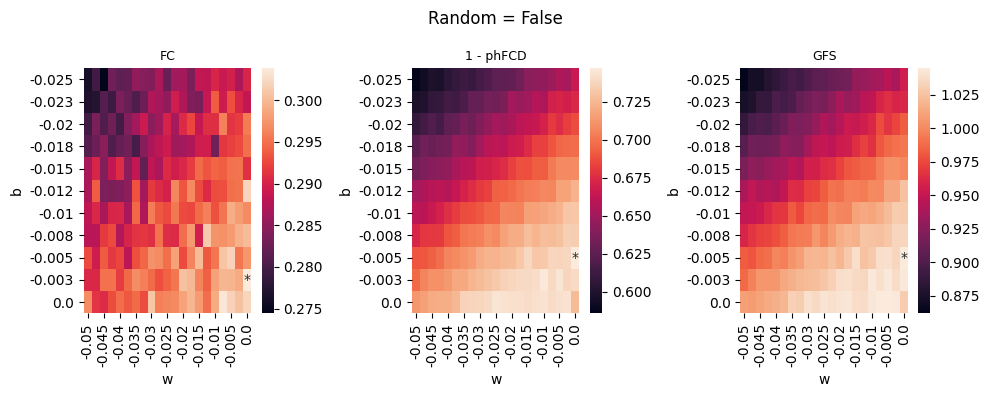

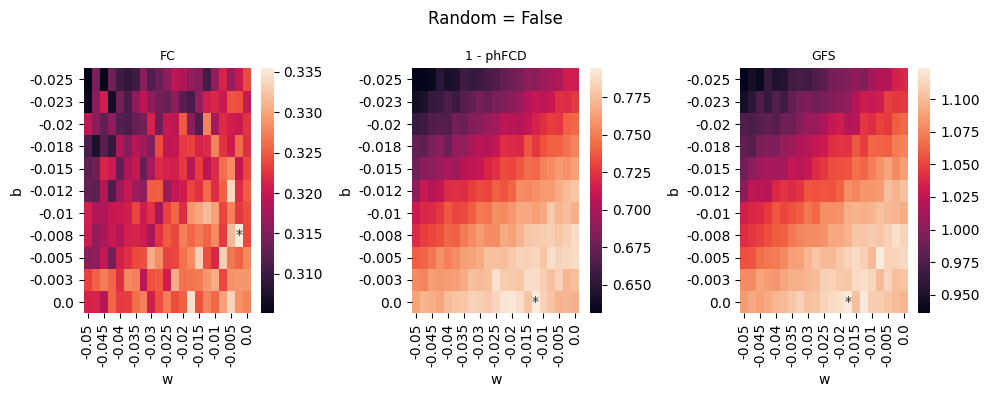

In [10]:
# Find the best b and w for the a-weight, G-weight and heterogeneous models
(
    best_fit_b_CN_a,
    best_fit_w_CN_a,
    best_fit_b_mci_a,
    best_fit_w_mci_a,
) = perform_group_analyses(df_petTOAD, df_a_big, random=False)
(
    best_fit_b_CN_G,
    best_fit_w_CN_G,
    best_fit_b_mci_G,
    best_fit_w_mci_G,
) = perform_group_analyses(df_petTOAD, df_G_big, random=False)
(
    best_fit_b_CN_het,
    best_fit_w_CN_het,
    best_fit_b_mci_het,
    best_fit_w_mci_het,
) = perform_group_analyses(df_petTOAD, df_het_big, False)

The best parameters found for these heatmaps are:
b = 0.0, w = -0.008, for CN with WMH
The best parameters found for these heatmaps are:
b = 0.0, w = -0.65, for CN with WMH
The best parameters found for these heatmaps are:
b = 0.0, w = -0.018, for CN with WMH


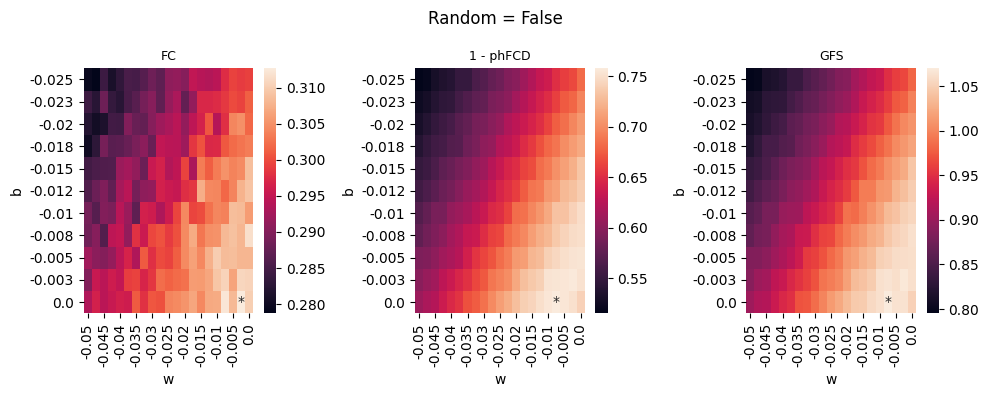

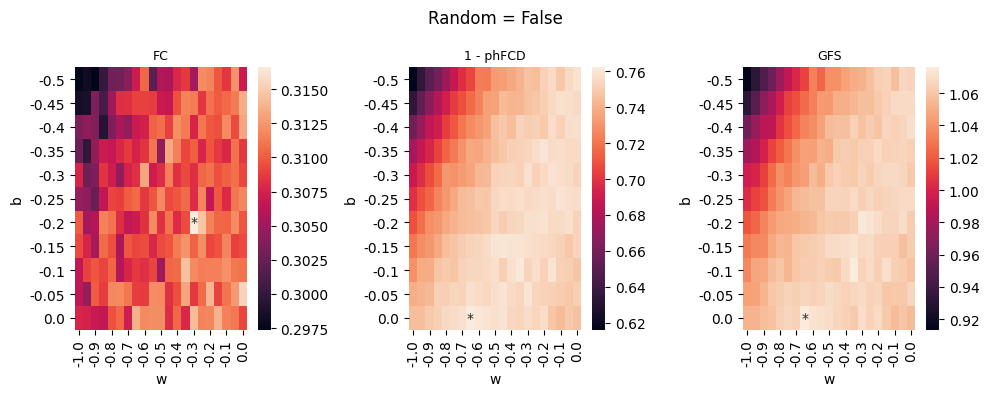

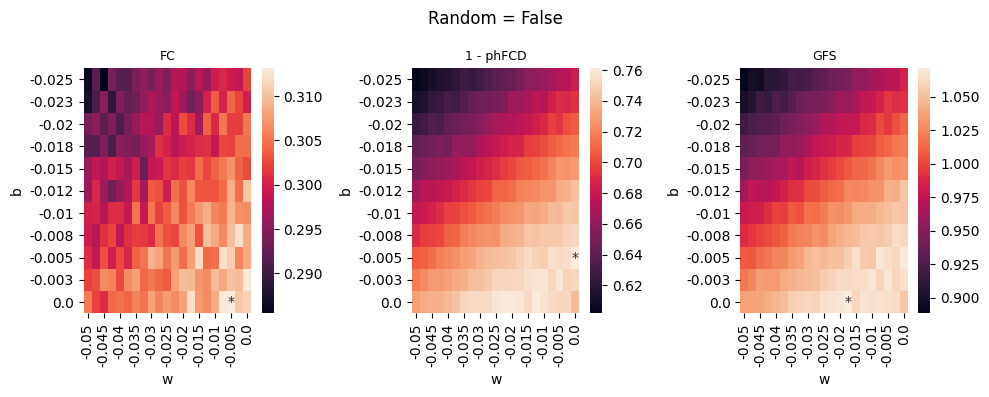

In [11]:
# Do analysis at WMH / no WMH level
best_fit_b_a, best_fit_w_a = perform_big_group_analyses(df_petTOAD, df_a_big, False)
best_fit_b_G, best_fit_w_G = perform_big_group_analyses(df_petTOAD, df_G_big, False)
best_fit_b_het, best_fit_w_het = perform_big_group_analyses(df_petTOAD, df_het_big, False)

In [47]:
def get_wmh_load_random():
    np.random.seed(1991)
    df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv")
    df_petTOAD["PTID"] = df_petTOAD["PTID"].str.replace("_", "")
    df_petTOAD["wmh_log"] = np.log(df_petTOAD["WMH_load_subj_space"])
    df_petTOAD["wmh_log"] = (
        df_petTOAD["wmh_log"] - df_petTOAD["wmh_log"].min()
    ) / (
        df_petTOAD["wmh_log"].max() - df_petTOAD["wmh_log"].min()
    )
    arr_wmh_rand = df_petTOAD["wmh_log"].to_numpy()
    np.random.shuffle(arr_wmh_rand)
    wmh_dict_rand = {subj: round(arr_wmh_rand[i],3) for i, subj in enumerate(subjs)}
    return wmh_dict_rand

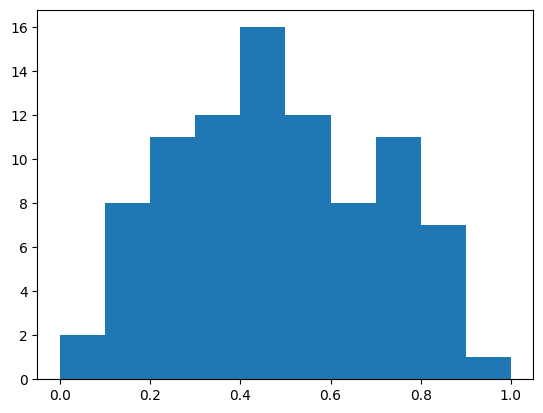

In [62]:
df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv")
df_petTOAD["PTID"] = df_petTOAD["PTID"].str.replace("_", "")
df_petTOAD["wmh_log"] = np.log(df_petTOAD["WMH_load_subj_space"])
df_petTOAD = df_petTOAD[(df_petTOAD["PTID"].isin(CN_WMH)) | (df_petTOAD["PTID"].isin(MCI_WMH))]
df_petTOAD["wmh_log"] = (
    df_petTOAD["wmh_log"] - df_petTOAD["wmh_log"].min()
) / (
    df_petTOAD["wmh_log"].max() - df_petTOAD["wmh_log"].min()
)
plt.hist(df_petTOAD["wmh_log"]);


In [12]:
# Set the random best to the same value as the non-random best
best_fit_b_a_rand, best_fit_w_a_rand = best_fit_b_a, best_fit_w_a
best_fit_b_G_rand, best_fit_w_G_rand = best_fit_b_G, best_fit_w_G
best_fit_b_het_rand, best_fit_w_het_rand = best_fit_b_het, best_fit_w_het


# We create merged databases with clinical information for the remaining models
df_a_big_boxplot = pd.merge(
    df_a_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

df_a_rand_big_boxplot = pd.merge(
    df_a_rand_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

df_het_big_boxplot = pd.merge(
    df_het_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

df_het_rand_big_boxplot = pd.merge(
    df_het_rand_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

df_G_big_boxplot = pd.merge(
    df_G_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

df_G_rand_big_boxplot = pd.merge(
    df_G_rand_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

df_sc_big_boxplot = pd.merge(
    df_sc_big, df_petTOAD[["PTID", "WMH_bin"]], on="PTID"
)

# Create df with only the best values from before for CN
df_boxplot_compare_base = create_df_boxplot_wmh(df_a_big_boxplot, 0, 0, "Base")
df_boxplot_compare_a = create_df_boxplot_wmh(
    df_a_big_boxplot, best_fit_b_a, best_fit_w_a, "Homo."
)
df_boxplot_compare_a_rand = create_df_boxplot_wmh(
    df_a_rand_big_boxplot,
    best_fit_b_a_rand,
    best_fit_w_a_rand,
    "Homo. rand.",
)
df_boxplot_compare_het = create_df_boxplot_wmh(
    df_het_big_boxplot, best_fit_b_het, best_fit_w_het, "Hetero."
)
df_boxplot_compare_het_rand = create_df_boxplot_wmh(
    df_het_rand_big_boxplot,
    best_fit_b_het_rand,
    best_fit_w_het_rand,
    "Hetero. rand.",
)
df_boxplot_compare_G = create_df_boxplot_wmh(
    df_G_big_boxplot, best_fit_b_G, best_fit_w_G, "G-weight"
)
df_boxplot_compare_G_rand = create_df_boxplot_wmh(
    df_G_rand_big_boxplot,
    best_fit_b_G_rand,
    best_fit_w_G_rand,
    "G rand.",
)
df_boxplot_compare_sc = df_sc_big_boxplot[
    df_sc_big_boxplot["WMH_bin"] == "WMH"
].drop(columns="WMH_bin")
# The structural disconnectivity model doesn't have a weight, so its processing is slightly different
df_boxplot_compare_sc["comp_score"] = (
    df_boxplot_compare_sc["fc_pearson"] + 1 * df_boxplot_compare_sc["phfcd_ks"]
)
df_boxplot_compare_sc["Model_type"] = "Disconn."

df_boxplot_compare = pd.concat(
    [
        df_boxplot_compare_base,
        df_boxplot_compare_a,
        df_boxplot_compare_het,
        df_boxplot_compare_G,
        df_boxplot_compare_sc,
    ]
)

# Create a unified long df to compare the model performance between random vs. non-random
df_boxplot_compare_rand = pd.concat(
    [
        df_boxplot_compare_a,
        df_boxplot_compare_a_rand,
        df_boxplot_compare_het,
        df_boxplot_compare_het_rand,
        df_boxplot_compare_G,
        df_boxplot_compare_G_rand,
    ]
)
df_boxplot_compare_rand["Random"] = np.where(
    df_boxplot_compare_rand["Model_type"].str.contains("rand."),
    "Random",
    "Not Random",
)

In [13]:
# Set the random best to the same value as the non-random best
best_fit_b_CN_a_rand, best_fit_w_CN_a_rand = best_fit_b_CN_a, best_fit_w_CN_a
best_fit_b_CN_G_rand, best_fit_w_CN_G_rand = best_fit_b_CN_G, best_fit_w_CN_G
best_fit_b_CN_het_rand, best_fit_w_CN_het_rand = best_fit_b_CN_het, best_fit_w_CN_het


# We create merged databases with clinical information for the remaining models
df_a_big_boxplot = pd.merge(
    df_a_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_a_rand_big_boxplot = pd.merge(
    df_a_rand_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_het_big_boxplot = pd.merge(
    df_het_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_het_rand_big_boxplot = pd.merge(
    df_het_rand_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_G_big_boxplot = pd.merge(
    df_G_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_G_rand_big_boxplot = pd.merge(
    df_G_rand_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_sc_big_boxplot = pd.merge(
    df_sc_big, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

# Create df with only the best values from before for CN
df_boxplot_compare_CN_base = create_df_boxplot(df_a_big_boxplot, 0, 0, "CN_WMH", "Base")
df_boxplot_compare_CN_a = create_df_boxplot(
    df_a_big_boxplot, best_fit_b_CN_a, best_fit_w_CN_a, "CN_WMH", "Homo."
)
df_boxplot_compare_CN_a_rand = create_df_boxplot(
    df_a_rand_big_boxplot,
    best_fit_b_CN_a_rand,
    best_fit_w_CN_a_rand,
    "CN_WMH",
    "Homo. rand.",
)
df_boxplot_compare_CN_het = create_df_boxplot(
    df_het_big_boxplot, best_fit_b_CN_het, best_fit_w_CN_het, "CN_WMH", "Hetero."
)
df_boxplot_compare_CN_het_rand = create_df_boxplot(
    df_het_rand_big_boxplot,
    best_fit_b_CN_het_rand,
    best_fit_w_CN_het_rand,
    "CN_WMH",
    "Hetero. rand.",
)
df_boxplot_compare_CN_G = create_df_boxplot(
    df_G_big_boxplot, best_fit_b_CN_G, best_fit_w_CN_G, "CN_WMH", "G-weight"
)
df_boxplot_compare_CN_G_rand = create_df_boxplot(
    df_G_rand_big_boxplot,
    best_fit_b_CN_G_rand,
    best_fit_w_CN_G_rand,
    "CN_WMH",
    "G rand.",
)
df_boxplot_compare_CN_sc = df_sc_big_boxplot[
    df_sc_big_boxplot["Group_Fazekas_2.0"] == "CN_WMH"
].drop(columns="Group_Fazekas_2.0")
# The structural disconnectivity model doesn't have a weight, so its processing is slightly different
df_boxplot_compare_CN_sc["comp_score"] = (
    df_boxplot_compare_CN_sc["fc_pearson"] + 1 * df_boxplot_compare_CN_sc["phfcd_ks"]
)
df_boxplot_compare_CN_sc["Model_type"] = "Disconn."

df_boxplot_compare_CN = pd.concat(
    [
        df_boxplot_compare_CN_base,
        df_boxplot_compare_CN_a,
        df_boxplot_compare_CN_het,
        df_boxplot_compare_CN_G,
        df_boxplot_compare_CN_sc,
    ]
)

In [14]:
# Set the random best to the same value as the non-random best
best_fit_b_mci_a_rand, best_fit_w_mci_a_rand = best_fit_b_mci_a, best_fit_w_mci_a
best_fit_b_mci_G_rand, best_fit_w_mci_G_rand = best_fit_b_mci_G, best_fit_w_mci_G
best_fit_b_mci_het_rand, best_fit_w_mci_het_rand = (
    best_fit_b_mci_het,
    best_fit_w_mci_het,
)

# Perform the same steps done with CN but on MCI
# Create df with only the best values from before for MCI
df_boxplot_compare_mci_base = create_df_boxplot(
    df_a_big_boxplot, 0, 0, "MCI_WMH", "Base"
)
df_boxplot_compare_mci_a = create_df_boxplot(
    df_a_big_boxplot, best_fit_b_mci_a, best_fit_w_mci_a, "MCI_WMH", "Homo."
)
df_boxplot_compare_mci_a_rand = create_df_boxplot(
    df_a_rand_big_boxplot,
    best_fit_b_mci_a_rand,
    best_fit_w_mci_a_rand,
    "MCI_WMH",
    "Homo. rand.",
)
df_boxplot_compare_mci_het = create_df_boxplot(
    df_het_big_boxplot, best_fit_b_mci_het, best_fit_w_mci_het, "MCI_WMH", "Hetero."
)
df_boxplot_compare_mci_het_rand = create_df_boxplot(
    df_het_rand_big_boxplot,
    best_fit_b_mci_het_rand,
    best_fit_w_mci_het_rand,
    "MCI_WMH",
    "Hetero. rand.",
)
df_boxplot_compare_mci_G = create_df_boxplot(
    df_G_big_boxplot, best_fit_b_mci_G, best_fit_w_mci_G, "MCI_WMH", "G-weight"
)
df_boxplot_compare_mci_G_rand = create_df_boxplot(
    df_G_rand_big_boxplot,
    best_fit_b_mci_G_rand,
    best_fit_w_mci_G_rand,
    "MCI_WMH",
    "G rand.",
)
df_boxplot_compare_mci_sc = df_sc_big_boxplot[
    df_sc_big_boxplot["Group_Fazekas_2.0"] == "MCI_WMH"
].drop(columns="Group_Fazekas_2.0")
df_boxplot_compare_mci_sc["comp_score"] = (
    df_boxplot_compare_mci_sc["fc_pearson"] + 1 * df_boxplot_compare_mci_sc["phfcd_ks"]
)
df_boxplot_compare_mci_sc["Model_type"] = "Disconn."
df_boxplot_compare_mci = pd.concat(
    [
        df_boxplot_compare_mci_base,
        df_boxplot_compare_mci_a,
        df_boxplot_compare_mci_het,
        df_boxplot_compare_mci_G,
        df_boxplot_compare_mci_sc,
    ]
)

In [15]:
# Create a unified long df to compare the model performance between random vs. non-random
df_boxplot_compare_rand_cn = pd.concat(
    [
        df_boxplot_compare_CN_a,
        df_boxplot_compare_CN_a_rand,
        df_boxplot_compare_CN_het,
        df_boxplot_compare_CN_het_rand,
        df_boxplot_compare_CN_G,
        df_boxplot_compare_CN_G_rand,
    ]
)
df_boxplot_compare_rand_cn["Random"] = np.where(
    df_boxplot_compare_rand_cn["Model_type"].str.contains("rand."),
    "Random",
    "Not Random",
)
df_boxplot_compare_rand_mci = pd.concat(
    [
        df_boxplot_compare_mci_a,
        df_boxplot_compare_mci_a_rand,
        df_boxplot_compare_mci_het,
        df_boxplot_compare_mci_het_rand,
        df_boxplot_compare_mci_G,
        df_boxplot_compare_mci_G_rand,
    ]
)
df_boxplot_compare_rand_mci["Random"] = np.where(
    df_boxplot_compare_rand_mci["Model_type"].str.contains("rand."),
    "Random",
    "Not Random",
)
# Create a unified long df to compare the model performance between groups
df_boxplot_compare_CN["group"] = "CN WMH"
df_boxplot_compare_mci["group"] = "MCI WMH"
df_boxplot_compare = pd.concat([df_boxplot_compare_CN, df_boxplot_compare_mci])

### Prepare dfs with maximum values achieved

In [16]:
# Now let's plot the best FC and 1-phFCDs achievable in the range of explored parameters
df_base_merged = pd.merge(df_base, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID")
df_base_merged["comp_score"] = (
    df_base_merged["fc_pearson"] + 1 * df_base_merged["phfcd_ks"]
)
df_max_comp_score_a_merged = pd.merge(
    df_max_comp_score_a, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)
df_max_comp_score_a_rand_merged = pd.merge(
    df_max_comp_score_a_rand, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)
df_max_comp_score_hetero_merged = pd.merge(
    df_max_comp_score_hetero, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)
df_max_comp_score_G_merged = pd.merge(
    df_max_comp_score_G, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)
df_max_comp_score_G_rand_merged = pd.merge(
    df_max_comp_score_G_rand, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)
df_max_comp_score_sc_merged = pd.merge(
    df_max_comp_score_sc, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_base_merged["Model_type"] = "Base"

df_max_comp_score_a_merged["Model_type"] = "Homo."
df_max_comp_score_a_rand_merged["Model_type"] = "Homo. rand."
df_max_comp_score_hetero_merged["Model_type"] = "Hetero."
df_max_comp_score_G_merged["Model_type"] = "G-weight"
df_max_comp_score_G_rand_merged["Model_type"] = "G rand."
df_max_comp_score_sc_merged["Model_type"] = "Disconn."

# df_max_phfcd_a_merged = pd.merge(
#     df_max_phfcd_a, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
# )
# df_max_phfcd_a_rand_merged = pd.merge(
#     df_max_phfcd_a_rand, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
# )
# df_max_phfcd_sc_merged = pd.merge(
#     df_max_phfcd_sc, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
# )
# df_max_phfcd_G_merged = pd.merge(
#     df_max_phfcd_G, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
# )
# df_max_phfcd_G_rand_merged = pd.merge(
#     df_max_phfcd_G_rand, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
# )
# df_max_phfcd_hetero_merged = pd.merge(
#     df_max_phfcd_hetero, df_petTOAD[["PTID", "Group_Fazekas_2.0"]], on="PTID"
# )

# df_max_phfcd_a_merged["Model_type"] = "Homo."
# df_max_phfcd_a_rand_merged["Model_type"] = "Homo. rand."
# df_max_phfcd_hetero_merged["Model_type"] = "Hetero."
# df_max_phfcd_G_merged["Model_type"] = "G-weight"
# df_max_phfcd_G_rand_merged["Model_type"] = "G rand."
# df_max_phfcd_sc_merged["Model_type"] = "Disconn."

In [17]:
# Select only CN
df_base_merged_CN = df_base_merged[df_base_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_comp_score_a_merged_CN = df_max_comp_score_a_merged[
    df_max_comp_score_a_merged["Group_Fazekas_2.0"] == "CN_WMH"
]
df_max_comp_score_a_rand_merged_CN = df_max_comp_score_a_rand_merged[
    df_max_comp_score_a_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"
]
df_max_comp_score_hetero_merged_CN = df_max_comp_score_hetero_merged[
    df_max_comp_score_hetero_merged["Group_Fazekas_2.0"] == "CN_WMH"
]
df_max_comp_score_G_merged_CN = df_max_comp_score_G_merged[
    df_max_comp_score_G_merged["Group_Fazekas_2.0"] == "CN_WMH"
]
df_max_comp_score_G_rand_merged_CN = df_max_comp_score_G_rand_merged[
    df_max_comp_score_G_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"
]
df_max_comp_score_sc_merged_CN = df_max_comp_score_sc_merged[
    df_max_comp_score_sc_merged["Group_Fazekas_2.0"] == "CN_WMH"
]

# df_max_phfcd_a_merged_CN = df_max_phfcd_a_merged[
#     df_max_phfcd_a_merged["Group_Fazekas_2.0"] == "CN_WMH"
# ]
# df_max_phfcd_a_rand_merged_CN = df_max_phfcd_a_rand_merged[
#     df_max_phfcd_a_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"
# ]
# df_max_phfcd_hetero_merged_CN = df_max_phfcd_hetero_merged[
#     df_max_phfcd_hetero_merged["Group_Fazekas_2.0"] == "CN_WMH"
# ]
# df_max_phfcd_hetero_merged_CN = df_max_phfcd_hetero_merged_CN.dropna()
# df_max_phfcd_G_merged_CN = df_max_phfcd_G_merged[
#     df_max_phfcd_G_merged["Group_Fazekas_2.0"] == "CN_WMH"
# ]
# df_max_phfcd_G_rand_merged_CN = df_max_phfcd_G_rand_merged[
#     df_max_phfcd_G_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"
# ]
# df_max_phfcd_sc_merged_CN = df_max_phfcd_sc_merged[
#     df_max_phfcd_sc_merged["Group_Fazekas_2.0"] == "CN_WMH"
# ]

df_max_comp_score_CN = pd.concat(
    [
        df_base_merged_CN,
        df_max_comp_score_a_merged_CN,
        df_max_comp_score_hetero_merged_CN,
        df_max_comp_score_G_merged_CN,
        df_max_comp_score_sc_merged_CN,
    ]
)

# df_max_phfcd_CN = pd.concat(
#     [
#         df_base_merged_CN,
#         df_max_phfcd_a_merged_CN,
#         df_max_phfcd_hetero_merged_CN,
#         df_max_phfcd_G_merged_CN,
#         df_max_phfcd_sc_merged_CN,
#     ]
# )

In [18]:
# Select only MCI
df_base_merged_mci = df_base_merged[df_base_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_comp_score_a_merged_mci = df_max_comp_score_a_merged[
    df_max_comp_score_a_merged["Group_Fazekas_2.0"] == "MCI_WMH"
]
df_max_comp_score_a_rand_merged_mci = df_max_comp_score_a_rand_merged[
    df_max_comp_score_a_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"
]
df_max_comp_score_hetero_merged_mci = df_max_comp_score_hetero_merged[
    df_max_comp_score_hetero_merged["Group_Fazekas_2.0"] == "MCI_WMH"
]
df_max_comp_score_G_merged_mci = df_max_comp_score_G_merged[
    df_max_comp_score_G_merged["Group_Fazekas_2.0"] == "MCI_WMH"
]
df_max_comp_score_G_rand_merged_mci = df_max_comp_score_G_rand_merged[
    df_max_comp_score_G_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"
]
df_max_comp_score_sc_merged_mci = df_max_comp_score_sc_merged[
    df_max_comp_score_sc_merged["Group_Fazekas_2.0"] == "MCI_WMH"
]

# df_max_phfcd_a_merged_mci = df_max_phfcd_a_merged[
#     df_max_phfcd_a_merged["Group_Fazekas_2.0"] == "MCI_WMH"
# ]
# df_max_phfcd_a_rand_merged_mci = df_max_phfcd_a_rand_merged[
#     df_max_phfcd_a_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"
# ]
# # This dataset contain multiple values for one pts, so we filter them out..
# df_max_phfcd_a_rand_merged_mci = df_max_phfcd_a_rand_merged_mci.drop_duplicates(
#     ["PTID"]
# )
# df_max_phfcd_hetero_merged_mci = df_max_phfcd_hetero_merged[
#     df_max_phfcd_hetero_merged["Group_Fazekas_2.0"] == "MCI_WMH"
# ]
# df_max_phfcd_G_merged_mci = df_max_phfcd_G_merged[
#     df_max_phfcd_G_merged["Group_Fazekas_2.0"] == "MCI_WMH"
# ]
# df_max_phfcd_G_rand_merged_mci = df_max_phfcd_G_rand_merged[
#     df_max_phfcd_G_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"
# ]
# df_max_phfcd_sc_merged_mci = df_max_phfcd_sc_merged[
#     df_max_phfcd_sc_merged["Group_Fazekas_2.0"] == "MCI_WMH"
# ]

df_max_comp_score_mci = pd.concat(
    [
        df_base_merged_mci,
        df_max_comp_score_a_merged_mci,
        df_max_comp_score_hetero_merged_mci,
        df_max_comp_score_G_merged_mci,
        df_max_comp_score_sc_merged_mci,
    ]
)
# df_max_phfcd_mci = pd.concat(
#     [
#         df_base_merged_mci,
#         df_max_phfcd_a_merged_mci,
#         df_max_phfcd_hetero_merged_mci,
#         df_max_phfcd_G_merged_mci,
#         df_max_phfcd_sc_merged_mci,
#     ]
# )

In [19]:
df_max_comp_score_a["a"] = (
    -0.02
    + df_max_comp_score_a["w"] * df_max_comp_score_a["wmh_load"]
    + df_max_comp_score_a["b"]
)
df_max_comp_score_G["G"] = (
    1.9
    + df_max_comp_score_G["w"] * df_max_comp_score_G["wmh_load"]
    + df_max_comp_score_G["b"]
)

df_max_comp_score_a_cn = df_max_comp_score_a[df_max_comp_score_a["PTID"].isin(CN_WMH)]
df_max_comp_score_a_mci = df_max_comp_score_a[df_max_comp_score_a["PTID"].isin(MCI_WMH)]
df_max_comp_score_G_cn = df_max_comp_score_G[df_max_comp_score_G["PTID"].isin(CN_WMH)]
df_max_comp_score_G_mci = df_max_comp_score_G[df_max_comp_score_G["PTID"].isin(MCI_WMH)]

df_max_comp_score_a_mci_mmse = pd.merge(df_max_comp_score_a_mci, df_petTOAD, on="PTID")
df_max_comp_score_a_cn_mmse = pd.merge(df_max_comp_score_a_cn, df_petTOAD, on="PTID")
df_max_comp_score_G_mci_mmse = pd.merge(df_max_comp_score_G_mci, df_petTOAD, on="PTID")
df_max_comp_score_G_cn_mmse = pd.merge(df_max_comp_score_G_cn, df_petTOAD, on="PTID")

In [20]:
df_max_comp_score_CN["group"] = "CN WMH"
df_max_comp_score_mci["group"] = "MCI WMH"
df_max_boxplot_compare = pd.concat([df_max_comp_score_CN, df_max_comp_score_mci])
# create tuples
df_max_rand_compare = pd.DataFrame()
list_tuples_df = [
    (df_max_comp_score_a, df_a_rand_big, "Homo."),
    (df_max_comp_score_G, df_G_rand_big, "G-weight"),
    (df_max_comp_score_hetero, df_het_rand_big, "Hetero."),
]
for tp in list_tuples_df:
    df_max_rand_compare = pd.concat(
        [df_max_rand_compare, create_df_max_rand(tp[0], tp[1], tp[2])]
    )
df_max_rand_compare["Group_Fazekas_2.0"] = np.where(
    df_max_rand_compare["PTID"].isin(CN_WMH), "CN_WMH", "MCI_WMH"
)
df_max_rand_compare["Random"] = "Random"
df_max_rand_compare["Model_type_composite"] = (
    df_max_rand_compare["Model_type"] + " " + "Random"
)
df_max_rand_compare_cn = df_max_rand_compare[
    df_max_rand_compare["Group_Fazekas_2.0"] == "CN_WMH"
]
df_max_rand_compare_mci = df_max_rand_compare[
    df_max_rand_compare["Group_Fazekas_2.0"] == "MCI_WMH"
]
df_max_comp_score_CN["Random"] = "Not Random"
df_max_comp_score_mci["Random"] = "Not Random"
df_max_comp_score_CN["Model_type_composite"] = (
    df_max_comp_score_CN["Model_type"] + df_max_comp_score_CN["Random"]
)
df_max_comp_score_mci["Model_type_composite"] = (
    df_max_comp_score_mci["Model_type"] + df_max_comp_score_mci["Random"]
)

df_max_comp_score_boxplot_compare_rand_cn = pd.concat(
    [df_max_rand_compare_cn, df_max_comp_score_CN]
)
df_max_comp_score_boxplot_compare_rand_mci = pd.concat(
    [df_max_rand_compare_mci, df_max_comp_score_mci]
)
df_max_comp_score_boxplot_compare_rand_cn = df_max_comp_score_boxplot_compare_rand_cn[
    (df_max_comp_score_boxplot_compare_rand_cn["Model_type"] != "Base")
    & (df_max_comp_score_boxplot_compare_rand_cn["Model_type"] != "Disconn.")
]
df_max_comp_score_boxplot_compare_rand_mci = df_max_comp_score_boxplot_compare_rand_mci[
    (df_max_comp_score_boxplot_compare_rand_mci["Model_type"] != "Base")
    & (df_max_comp_score_boxplot_compare_rand_mci["Model_type"] != "Disconn.")
]

# Analyses

## Summary statistics and tables

In [21]:
# Read in data
n_pts = len(df_petTOAD)
age_min = round(df_petTOAD.describe()["Age"]["min"], 0)
age_max = round(df_petTOAD.describe()["Age"]["max"], 0)
sex_counts = df_petTOAD["Sex"].value_counts()
DX_counts = df_petTOAD["Group"].value_counts()
females_num = sex_counts["F"]
males_num = sex_counts["M"]
cu_num = DX_counts["CN"]
mci_num = DX_counts["MCI"]

cu_no_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"])
cu_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"])
mci_no_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"])
mci_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"])

print(
    f"After exclusion, {n_pts} patients (age-range: {age_min}-{age_max}, {females_num} ({round(females_num / n_pts * 100, 2)}%) females, {males_num} ({round(males_num / n_pts * 100, 2)}%) males, {cu_num} ({round(cu_num / n_pts* 100, 1)}%) CU and {mci_num} ({round(mci_num / n_pts * 100, 1)}%) MCI) were considered for the modeling pipeline."
)
print(
    f"Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2."
)
print(
    f"Accordingly, there were: {cu_no_wmh} ({round(cu_no_wmh / cu_num * 100, 1)}%) CU without WMH, {cu_wmh} ({round(cu_wmh / cu_num * 100, 1)}%) CU with WMH, {mci_no_wmh} ({round(mci_no_wmh / mci_num * 100, 1)}%) MCI without WMH, {mci_wmh} ({round(mci_wmh / mci_num* 100, 1)}%) MCI with WMH,"
)
# Create contingency table for comparing Fazekas binary classification between groups with Chi-squared
ct_wmh = pd.crosstab(df_petTOAD["WMH_bin"], df_petTOAD["Group"])
_, p_wmh, _, _ = stats.chi2_contingency(ct_wmh)
if p_wmh < 0.05:
    print(
        f"with statistically significant differences in frequency between subgroups (p = {round(p_wmh,3)})"
    )
else:
    print(
        f"with no statistically significant differences in frequency between subgroups (p = {round(p_wmh, 3)})"
    )
# Get age summary stats
age_summary = df_petTOAD.groupby(["Group"])["Age"].describe()
age_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])["Age"].describe()
print("################# Results #################")
print("# Age #")
pval_age_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["Age"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["Age"],
)[1]
pval_age_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["Age"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["Age"],
)[1]
pval_age_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["Age"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["Age"],
)[1]
print(
    f"Median age for CU subjects = {age_summary['50%']['CN']} (IQR = {age_summary['25%']['CN']} - {age_summary['75%']['CN']})"
)
print(
    f"Median age for MCI subjects = {age_summary['50%']['MCI']} (IQR = {age_summary['25%']['MCI']} - {age_summary['75%']['MCI']})"
)
print(f"P-value age CU vs MCI: {round(pval_age_diff_cn_vs_mci, 5)}")

print(
    f"Median age for CU no WMH subjects = {age_summary_subgroups['50%']['CN_no_WMH']} (IQR = {age_summary_subgroups['25%']['CN_no_WMH']} - {age_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median age for CU WMH subjects = {age_summary_subgroups['50%']['CN_WMH']} (IQR = {age_summary_subgroups['25%']['CN_WMH']} - {age_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value age CU no WMH vs CU WMH: {round(pval_age_diff_cn_no_wmh_vs_wmh, 5)}")

print(
    f"Median age for MCI no WMH subjects = {age_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {age_summary_subgroups['25%']['MCI_no_WMH']} - {age_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median age for MCI WMH subjects = {age_summary_subgroups['50%']['MCI_WMH']} (IQR = {age_summary_subgroups['25%']['MCI_WMH']} - {age_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value age MCI no WMH vs MCI WMH: {round(pval_age_diff_mci_no_wmh_vs_wmh, 5)}")


print("# WMH #")
wmh_summary = df_petTOAD.groupby(["Group"])["WMH_load_subj_space"].describe()
wmh_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])[
    "WMH_load_subj_space"
].describe()

pval_wmh_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["WMH_load_subj_space"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["WMH_load_subj_space"],
)[1]
pval_wmh_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["WMH_load_subj_space"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["WMH_load_subj_space"],
)[1]
pval_wmh_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["WMH_load_subj_space"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["WMH_load_subj_space"],
)[1]

print(
    f"Median WMH volume load for CN subjects = {wmh_summary['50%']['CN']} (IQR = {wmh_summary['25%']['CN']} - {wmh_summary['75%']['CN']})"
)
print(
    f"Median WMH volume load for MCI subjects = {wmh_summary['50%']['MCI']} (IQR = {wmh_summary['25%']['MCI']} - {wmh_summary['75%']['MCI']})"
)
print(f"P-value WMH volum CU vs MCI: {pval_wmh_diff_cn_vs_mci}")

print(
    f"Median WMH volume load for CN no WMH subjects = {wmh_summary_subgroups['50%']['CN_no_WMH']} (IQR = {wmh_summary_subgroups['25%']['CN_no_WMH']} - {wmh_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median WMH volume load for CN WMH subjects = {wmh_summary_subgroups['50%']['CN_WMH']} (IQR = {wmh_summary_subgroups['25%']['CN_WMH']} - {wmh_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value WMH volume CU no WMH vs CU WMH: {pval_wmh_diff_cn_no_wmh_vs_wmh}")

print(
    f"Median WMH volume load for MCI no WMH subjects = {wmh_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {wmh_summary_subgroups['25%']['MCI_no_WMH']} - {wmh_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median WMH volume load for MCI WMH subjects = {wmh_summary_subgroups['50%']['MCI_WMH']} (IQR = {wmh_summary_subgroups['25%']['MCI_WMH']} - {wmh_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value WMH volume MCI no WMH vs MCI WMH: {pval_wmh_diff_mci_no_wmh_vs_wmh}")

print("# MMSE #")
mmse_summary = df_petTOAD.groupby(["Group"])["MMSE"].describe()
mmse_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])["MMSE"].describe()

pval_mmse_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["MMSE"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["MMSE"],
)[1]
pval_mmse_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["MMSE"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["MMSE"],
)[1]
pval_mmse_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["MMSE"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["MMSE"],
)[1]

print(
    f"Median MMSE score for CN subjects = {mmse_summary['50%']['CN']} (IQR = {mmse_summary['25%']['CN']} - {mmse_summary['75%']['CN']})"
)
print(
    f"Median MMSE score for MCI subjects = {mmse_summary['50%']['MCI']} (IQR = {mmse_summary['25%']['MCI']} - {mmse_summary['75%']['MCI']})"
)
print(f"P-value MMSE score CU vs MCI: {pval_mmse_diff_cn_vs_mci}")

print(
    f"Median MMSE score for CN no WMH subjects = {mmse_summary_subgroups['50%']['CN_no_WMH']} (IQR = {mmse_summary_subgroups['25%']['CN_no_WMH']} - {mmse_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median MMSE score for CN WMH subjects = {mmse_summary_subgroups['50%']['CN_WMH']} (IQR = {mmse_summary_subgroups['25%']['CN_WMH']} - {mmse_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value MMSE score CU no WMH vs CU WMH: {pval_mmse_diff_cn_no_wmh_vs_wmh}")

print(
    f"Median MMSE score for MCI no WMH subjects = {mmse_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {mmse_summary_subgroups['25%']['MCI_no_WMH']} - {mmse_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median MMSE score for MCI WMH subjects = {mmse_summary_subgroups['50%']['MCI_WMH']} (IQR = {mmse_summary_subgroups['25%']['MCI_WMH']} - {mmse_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value MMSE score MCI no WMH vs MCI WMH: {pval_mmse_diff_mci_no_wmh_vs_wmh}")

print("# Education #")
educ_summary = df_petTOAD.groupby(["Group"])["PTEDUCAT"].describe()
educ_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])[
    "PTEDUCAT"
].describe()

pval_educ_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["PTEDUCAT"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["PTEDUCAT"],
)[1]
pval_educ_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["PTEDUCAT"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["PTEDUCAT"],
)[1]
pval_educ_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["PTEDUCAT"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["PTEDUCAT"],
)[1]

print(
    f"Median MMSE score for CN subjects = {educ_summary['50%']['CN']} (IQR = {educ_summary['25%']['CN']} - {educ_summary['75%']['CN']})"
)
print(
    f"Median MMSE score for MCI subjects = {educ_summary['50%']['MCI']} (IQR = {educ_summary['25%']['MCI']} - {educ_summary['75%']['MCI']})"
)
print(f"P-value MMSE score CU vs MCI: {pval_educ_diff_cn_vs_mci}")

print(
    f"Median MMSE score for CN no WMH subjects = {educ_summary_subgroups['50%']['CN_no_WMH']} (IQR = {educ_summary_subgroups['25%']['CN_no_WMH']} - {educ_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median MMSE score for CN WMH subjects = {educ_summary_subgroups['50%']['CN_WMH']} (IQR = {educ_summary_subgroups['25%']['CN_WMH']} - {educ_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value MMSE score CU no WMH vs CU WMH: {pval_educ_diff_cn_no_wmh_vs_wmh}")

print(
    f"Median MMSE score for MCI no WMH subjects = {educ_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {educ_summary_subgroups['25%']['MCI_no_WMH']} - {educ_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median MMSE score for MCI WMH subjects = {educ_summary_subgroups['50%']['MCI_WMH']} (IQR = {educ_summary_subgroups['25%']['MCI_WMH']} - {educ_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value MMSE score MCI no WMH vs MCI WMH: {pval_educ_diff_mci_no_wmh_vs_wmh}")


print("# Sex #")
# Create contingency table for chi-squared
ct_sex = pd.crosstab(df_petTOAD["Sex"], df_petTOAD["Group"])
c_sex, p_sex, _, _ = stats.chi2_contingency(ct_sex)
if p_sex < 0.05:
    print(
        f"MCI and CU showed statistically significant sex differences, p = {round(p_sex, 3)}"
    )
else:
    print(f"MCI and CU showed no sex groups differences, p = {round(p_sex,3)}")

# Create contingency table for chi-squared
ct_sex_wmh = pd.crosstab(df_petTOAD["Sex"], df_petTOAD["Group_Fazekas_2.0"])
ct_sex_cn = ct_sex_wmh.iloc[:2, :2]
c_sex_cn, p_sex_cn, _, _ = stats.chi2_contingency(ct_sex_cn)
if p_sex_cn < 0.05:
    print(
        f"CU WMH and CU no WMH showed statistically significant sex differences, p = {round(p_sex_cn, 3)}"
    )
else:
    print(
        f"CU WMH and CU no WMH showed no sex groups differences, p = {round(p_sex_cn,3)}"
    )

# Create contingency table for chi-squared
ct_sex_mci = ct_sex_wmh.iloc[:2, 2:]
c_sex_mci, p_sex_mci, _, _ = stats.chi2_contingency(ct_sex_mci)
if p_sex_mci < 0.05:
    print(
        f"CU WMH and CU no WMH showed statistically significant sex differences, p = {round(p_sex_mci, 3)}"
    )
else:
    print(
        f"MCI WMH and MCI no WMH showed no sex groups differences, p = {round(p_sex_mci,3)}"
    )

After exclusion, 188 patients (age-range: 56.0-90.0, 101 (53.72%) females, 87 (46.28%) males, 120 (63.8%) CU and 68 (36.2%) MCI) were considered for the modeling pipeline.
Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2.
Accordingly, there were: 63 (52.5%) CU without WMH, 57 (47.5%) CU with WMH, 37 (54.4%) MCI without WMH, 31 (45.6%) MCI with WMH,
with no statistically significant differences in frequency between subgroups (p = 0.92)
################# Results #################
# Age #
Median age for CU subjects = 69.5 (IQR = 66.0 - 76.0)
Median age for MCI subjects = 72.0 (IQR = 68.75 - 79.0)
P-value age CU vs MCI: 0.03996
Median age for CU no WMH subjects = 68.0 (IQR = 66.0 - 71.5)
Median age for CU WMH subjects = 73.0 (IQR = 68.0 - 77.0)
P-value age CU no WMH vs CU WMH: 0.00055
Median age for MCI no WMH subjects = 71.0 (IQR = 65.0 - 76.0)
Median age for MCI WMH subjects = 76.0 (IQR = 71.5 - 79.5)
P-value age MCI no WMH 

In [22]:
# Create a summary DataFrame
summary_data = {
    "Age Median (IQR)": [
        f"{age_summary['50%']['CN']} ({age_summary['25%']['CN']} - {age_summary['75%']['CN']})",
        f"{age_summary['50%']['MCI']} ({age_summary['25%']['MCI']} - {age_summary['75%']['MCI']})",
        f"{round(pval_age_diff_cn_vs_mci, 4)}",
    ],
    "Sex n (%)": ["", "", round(p_sex, 3)],
    "Woman": [
        f"{ct_sex.iloc[0, 0]} ({round(ct_sex.iloc[0, 0]/cu_num * 100, 1)}%)",
        f"{ct_sex.iloc[0, 1]} ({round(ct_sex.iloc[0, 1] / mci_num * 100, 1)}%)",
        "",
    ],
    "Man": [
        f"{ct_sex.iloc[1, 0]} ({round(ct_sex.iloc[1, 0]/cu_num * 100, 1)}%)",
        f"{ct_sex.iloc[1, 1]} ({round(ct_sex.iloc[1, 1] / mci_num * 100, 1)}%)",
        "",
    ],
    "WMH volume (mm^3)": [
        f"{int(wmh_summary['50%']['CN'])} ({int(wmh_summary['25%']['CN'])}-{int(wmh_summary['75%']['CN'])})",
        f"{int(wmh_summary['50%']['MCI'])} ({int(wmh_summary['25%']['MCI'])}-{int(wmh_summary['75%']['MCI'])})",
        f"{round(pval_wmh_diff_cn_vs_mci, 3)}",
    ],
    "Fazekas score binned n (%)": ["", "", round(p_wmh, 3)],
    "WMH": [
        f"{ct_wmh.iloc[0, 0]} ({round(ct_wmh.iloc[0, 0]/cu_num * 100, 1)}%)",
        f"{ct_wmh.iloc[0, 1]} ({round(ct_wmh.iloc[0, 1] / mci_num * 100, 1)}%)",
        "",
    ],
    "no WMH": [
        f"{ct_wmh.iloc[1, 0]} ({round(ct_wmh.iloc[1, 0]/cu_num * 100, 1)}%)",
        f"{ct_wmh.iloc[1, 1]} ({round(ct_wmh.iloc[1, 1] / mci_num * 100, 1)}%)",
        "",
    ],
}

# Create the summary DataFrame
df_summary = pd.DataFrame(data=summary_data)

# Print the summary DataFrame
df_table1_bis = df_summary.T
df_table1_bis.columns = [f"CU, n = {cu_num}", f"MCI, n = {mci_num}", "p-value"]
#df_table1_bis.to_csv(RES_DIR / "table_1_group_together.csv")
df_table1_bis

,"CU, n = 120","MCI, n = 68",p-value
Age Median (IQR),69.5 (66.0 - 76.0),72.0 (68.75 - 79.0),0.04
Sex n (%),,,0.014
Woman,73 (60.8%),28 (41.2%),
Man,47 (39.2%),40 (58.8%),
WMH volume (mm^3),4686 (2054-11644),4524 (2294-12377),0.629
Fazekas score binned n (%),,,0.92
WMH,57 (47.5%),31 (45.6%),
no WMH,63 (52.5%),37 (54.4%),


In [23]:
# Create a summary DataFrame
summary_data = {
    "Age Median (IQR)": [
        f"{age_summary_subgroups['50%']['CN_no_WMH']} ({age_summary_subgroups['25%']['CN_no_WMH']} - {age_summary_subgroups['75%']['CN_no_WMH']})",
        f"{age_summary_subgroups['50%']['CN_WMH']} ({age_summary_subgroups['25%']['CN_WMH']} - {age_summary_subgroups['75%']['CN_WMH']})",
        f"{round(pval_age_diff_cn_no_wmh_vs_wmh, 3)}",
        f"{age_summary_subgroups['50%']['MCI_no_WMH']} ({age_summary_subgroups['25%']['MCI_no_WMH']} - {age_summary_subgroups['75%']['MCI_no_WMH']})",
        f"{age_summary_subgroups['50%']['MCI_WMH']} ({age_summary_subgroups['25%']['MCI_WMH']} - {age_summary_subgroups['75%']['MCI_WMH']})",
        f"{round(pval_age_diff_mci_no_wmh_vs_wmh, 3)}",
    ],
    "Sex n (%)": ["", "", round(p_sex_cn, 3), "", "", round(p_sex_mci)],
    "Woman": [
        f"{ct_sex_cn['CN_no_WMH']['F']} ({round(ct_sex_cn['CN_no_WMH']['F'] / ct_sex_cn['CN_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_cn['CN_WMH']['F']} ({round(ct_sex_cn['CN_WMH']['F'] / ct_sex_cn['CN_WMH'].sum() * 100, 1)}%)",
        " ",
        f"{ct_sex_mci['MCI_no_WMH']['F']} ({round(ct_sex_mci['MCI_no_WMH']['F'] / ct_sex_mci['MCI_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_mci['MCI_WMH']['F']} ({round(ct_sex_mci['MCI_WMH']['F'] / ct_sex_mci['MCI_WMH'].sum() * 100, 1)}%)",
        " ",
    ],
    "Man": [
        f"{ct_sex_cn['CN_no_WMH']['M']} ({round(ct_sex_cn['CN_no_WMH']['M'] / ct_sex_cn['CN_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_cn['CN_WMH']['M']} ({round(ct_sex_cn['CN_WMH']['M'] / ct_sex_cn['CN_WMH'].sum() * 100, 1)}%)",
        " ",
        f"{ct_sex_mci['MCI_no_WMH']['M']} ({round(ct_sex_mci['MCI_no_WMH']['M'] / ct_sex_mci['MCI_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_mci['MCI_WMH']['M']} ({round(ct_sex_mci['MCI_WMH']['M'] / ct_sex_mci['MCI_WMH'].sum() * 100, 1)}%)",
        " ",
    ],
    "WMH volume (mm^3)": [
        f"{int(wmh_summary_subgroups['50%']['CN_no_WMH'])} ({int(wmh_summary_subgroups['25%']['CN_no_WMH'])}-{int(wmh_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(wmh_summary_subgroups['50%']['CN_WMH'])} ({int(wmh_summary_subgroups['25%']['CN_WMH'])}-{int(wmh_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_wmh_diff_cn_no_wmh_vs_wmh, 20)}",
        f"{int(wmh_summary_subgroups['50%']['MCI_no_WMH'])} ({int(wmh_summary_subgroups['25%']['MCI_no_WMH'])}-{int(wmh_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(wmh_summary_subgroups['50%']['MCI_WMH'])} ({int(wmh_summary_subgroups['25%']['MCI_WMH'])}-{int(wmh_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_wmh_diff_mci_no_wmh_vs_wmh, 20)}",
    ],
    "MMSE": [
        f"{int(mmse_summary_subgroups['50%']['CN_no_WMH'])} ({int(mmse_summary_subgroups['25%']['CN_no_WMH'])}-{int(mmse_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(mmse_summary_subgroups['50%']['CN_WMH'])} ({int(mmse_summary_subgroups['25%']['CN_WMH'])}-{int(mmse_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_mmse_diff_cn_no_wmh_vs_wmh, 2)}",
        f"{int(mmse_summary_subgroups['50%']['MCI_no_WMH'])} ({int(mmse_summary_subgroups['25%']['MCI_no_WMH'])}-{int(mmse_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(mmse_summary_subgroups['50%']['MCI_WMH'])} ({int(mmse_summary_subgroups['25%']['MCI_WMH'])}-{int(mmse_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_mmse_diff_mci_no_wmh_vs_wmh, 2)}",
    ],
    "Education (yrs)": [
        f"{int(educ_summary_subgroups['50%']['CN_no_WMH'])} ({int(educ_summary_subgroups['25%']['CN_no_WMH'])}-{int(educ_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(educ_summary_subgroups['50%']['CN_WMH'])} ({int(educ_summary_subgroups['25%']['CN_WMH'])}-{int(educ_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_educ_diff_cn_no_wmh_vs_wmh, 2)}",
        f"{int(educ_summary_subgroups['50%']['MCI_no_WMH'])} ({int(educ_summary_subgroups['25%']['MCI_no_WMH'])}-{int(educ_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(educ_summary_subgroups['50%']['MCI_WMH'])} ({int(educ_summary_subgroups['25%']['MCI_WMH'])}-{int(educ_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_educ_diff_mci_no_wmh_vs_wmh, 2)}",
    ],
}

# Create the summary DataFrame
df_summary = pd.DataFrame(data=summary_data)

# Print the summary DataFrame
df_table1 = df_summary.T
df_table1.columns = [
    f"CU no WMH (n = {cu_no_wmh})",
    f"CU WMH (n = {cu_wmh})",
    "p",
    f"MCI no WMH (n = {mci_no_wmh})",
    f"MCI WMH (n = {mci_wmh})",
    "p-val",
]
#df_table1.to_csv(RES_DIR / "table_1.csv")
df_table1

,CU no WMH (n = 63),CU WMH (n = 57),p,MCI no WMH (n = 37),MCI WMH (n = 31),p-val
Age Median (IQR),68.0 (66.0 - 71.5),73.0 (68.0 - 77.0),0.001,71.0 (65.0 - 76.0),76.0 (71.5 - 79.5),0.003
Sex n (%),,,0.494,,,1
Woman,36 (57.1%),37 (64.9%),,15 (40.5%),13 (41.9%),
Man,27 (42.9%),20 (35.1%),,22 (59.5%),18 (58.1%),
WMH volume (mm^3),2083 (912-3446),12202 (6950-23818),1.507e-17,2456 (1629-4416),13519 (6451-24825),2.17188538875e-09
MMSE,29 (29-30),29 (29-30),0.47,29 (28-29),28 (27-29),0.52
Education (yrs),18 (16-18),16 (14-18),0.06,16 (15-18),16 (15-18),0.96


In [24]:
import statsmodels.api as sm


def lin_reg_wmh_a_G(df, x, y):
    # Use statsmodels to calculate p-values for the coefficients
    X_with_intercept = sm.add_constant(
        df[x]
    )  # Add a constant (intercept) term to the features
    model = sm.OLS(
        df[y], X_with_intercept
    ).fit()  # Fit an OLS (ordinary least squares) model
    # Get the coefficients (w) and intercept (b)
    w = model.params[x]
    b = model.params["const"]
    r2 = model.rsquared
    p = model.pvalues[x]

    return w, b, r2, p


w_a_cn, int_a_cn, r2_a_cn, p_a_cn = lin_reg_wmh_a_G(
    df_max_comp_score_a_cn_mmse, "wmh_load", "a"
)
w_G_cn, int_G_cn, r2_G_cn, p_G_cn = lin_reg_wmh_a_G(
    df_max_comp_score_G_cn_mmse, "wmh_load", "G"
)
w_a_mci, int_a_mci, r2_a_mci, p_a_mci = lin_reg_wmh_a_G(
    df_max_comp_score_a_mci_mmse, "wmh_load", "a"
)
w_G_mci, int_G_mci, r2_G_mci, p_G_mci = lin_reg_wmh_a_G(
    df_max_comp_score_G_mci_mmse, "wmh_load", "G"
)

b_a_cn = int_a_cn + 0.02
b_G_cn = int_G_cn - 1.9
b_a_mci = int_a_mci + 0.02
b_G_mci = int_G_mci - 1.9

dict_summary_best_w_b = {
    "": ["b", "w", "r^2", "p-value", "b", "w", "r^2", "p-value",],
    "Homogeneous a-weighted": [
        f"{round(b_a_cn, 3)}",
        f"{round(w_a_cn, 3)}",
        f"{round(r2_a_cn, 3)}",
        f"{round(p_a_cn, 3)}",
        f"{round(b_a_mci, 3)}",
        f"{round(w_a_mci, 3)}",
        f"{round(r2_a_mci, 3)}",
        f"{round(p_a_mci, 3)}",
    ],
    "G-weighted model": [
        f"{round(b_G_cn, 3)}",
        f"{round(w_G_cn, 3)}",
        f"{round(r2_G_cn, 3)}",
        f"{round(p_G_cn, 3)}",
        f"{round(b_G_mci, 3)}",
        f"{round(w_G_mci, 3)}",
        f"{round(r2_G_mci, 3)}",
        f"{round(p_G_mci, 3)}",

    ],
}
df_summary_best_w_b = pd.DataFrame.from_dict(dict_summary_best_w_b).T
df_summary_best_w_b.columns = ["CU WMH", "", "", "", "MCI WMH", "", "", ""]
#df_summary_best_w_b.to_csv(RES_DIR / "table2.csv")
print("CU WMH, r2, p for a:", r2_a_cn, p_a_cn)
print("CU WMH, r2, p for G:", r2_G_cn, p_G_cn)
print("MCI WMH, r2, p for a:", r2_a_mci, p_a_mci)
print("MCI WMH, r2, p for G:", r2_G_mci, p_G_mci)
df_summary_best_w_b

CU WMH, r2, p for a: 0.07201316409315606 0.04553061996179035
CU WMH, r2, p for G: 0.19338437742751902 0.0006959602338112546
MCI WMH, r2, p for a: 0.16934914310154192 0.02144453767179825
MCI WMH, r2, p for G: 0.21380710570486272 0.00881847772760626


,CU WMH,,,,MCI WMH,,,
,b,w,r^2,p-value,b,w,r^2,p-value
Homogeneous a-weighted,-0.004,-0.012,0.072,0.046,-0.005,-0.011,0.169,0.021
G-weighted model,-0.178,-0.702,0.193,0.001,-0.193,-0.404,0.214,0.009


In [25]:
w_a, int_a, r2_a, p_a = lin_reg_wmh_a_G(
    df_max_comp_score_a, "wmh_load", "a"
)
w_G, int_G, r2_G, p_G = lin_reg_wmh_a_G(
    df_max_comp_score_G, "wmh_load", "G"
)

b_a = int_a + 0.02
b_G = int_G - 1.9

dict_summary_best_w_b = {
    "": ["b", "w", "r^2", "p-value"],
    "Homogeneous a-weighted": [
        f"{round(b_a, 3)}",
        f"{round(w_a, 3)}",
        f"{round(r2_a, 3)}",
        f"{round(p_a, 3)}",
    ],
    "G-weighted model": [
        f"{round(b_G, 3)}",
        f"{round(w_G, 3)}",
        f"{round(r2_G, 3)}",
        f"{round(p_G, 3)}",

    ],
}
df_summary_best_w_b = pd.DataFrame.from_dict(dict_summary_best_w_b).T
df_summary_best_w_b.columns = ["All", "", "", ""]
df_summary_best_w_b

,All,,,
,b,w,r^2,p-value
Homogeneous a-weighted,-0.004,-0.012,0.104,0.002
G-weighted model,-0.193,-0.526,0.18,0.0


## Figures 

In [26]:
df_max_comp_score_boxplot_compare_rand = pd.concat([df_max_comp_score_boxplot_compare_rand_cn, df_max_comp_score_boxplot_compare_rand_mci])
df_max_comp_score = pd.concat([df_max_comp_score_CN, df_max_comp_score_mci])

In [27]:
list_pts_rand = df_max_comp_score_boxplot_compare_rand[df_max_comp_score_boxplot_compare_rand["Model_type_composite"] == "G-weight Random"]["PTID"].to_list()
list_pts_not_rand = df_max_comp_score_boxplot_compare_rand[df_max_comp_score_boxplot_compare_rand["Model_type_composite"] == "G-weightNot Random"]["PTID"].to_list()
print(list_pts_not_rand)
print(set(list_pts_rand).difference(set(list_pts_not_rand)))

['ADNI002S6456', 'ADNI024S6005', 'ADNI037S4214', 'ADNI109S6213', 'ADNI014S6831', 'ADNI032S6294', 'ADNI035S4464', 'ADNI114S6524', 'ADNI068S2315', 'ADNI032S6293', 'ADNI022S2263', 'ADNI037S6144', 'ADNI002S6066', 'ADNI141S6061', 'ADNI041S6801', 'ADNI035S6195', 'ADNI037S6032', 'ADNI941S6044', 'ADNI002S6007', 'ADNI141S6008', 'ADNI019S6186', 'ADNI002S1280', 'ADNI068S2184', 'ADNI168S6281', 'ADNI006S6209', 'ADNI168S6350', 'ADNI114S6813', 'ADNI032S6211', 'ADNI006S6234', 'ADNI168S6233', 'ADNI011S6714', 'ADNI014S4576', 'ADNI014S6424', 'ADNI168S6413', 'ADNI020S6470', 'ADNI041S6136', 'ADNI114S6309', 'ADNI168S6492', 'ADNI941S6080', 'ADNI301S6224', 'ADNI116S4855', 'ADNI003S6256', 'ADNI114S6113', 'ADNI024S6202', 'ADNI013S4580', 'ADNI116S6750', 'ADNI020S6185', 'ADNI012S4643', 'ADNI116S4453', 'ADNI002S6053', 'ADNI070S6394', 'ADNI041S6192', 'ADNI168S6318', 'ADNI020S6504', 'ADNI035S6751', 'ADNI035S6551', 'ADNI006S6770', 'ADNI024S4674', 'ADNI006S6674', 'ADNI006S6610', 'ADNI068S4067', 'ADNI011S6618', 'ADNI16

In [28]:
df_max_comp_score_boxplot_compare_rand.groupby("Model_type_composite")["PTID"].describe()

,count,unique,top,freq
Model_type_composite,,,,
G-weight Random,87,87,ADNI002S6456,1
G-weightNot Random,87,87,ADNI002S6456,1
Hetero. Random,87,87,ADNI002S6456,1
Hetero.Not Random,87,87,ADNI002S6456,1
Homo. Random,87,87,ADNI002S6456,1
Homo.Not Random,87,87,ADNI002S6456,1


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:7.641e-13 Stat=0.000e+00
Homo. vs. Hetero.: Wilcoxon test (paired samples), P_val:6.500e-03 Stat=1.271e+03
Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:9.934e-06 Stat=8.700e+02
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:1.337e-13 Stat=1.650e+02
Homo. vs. G-weight: Wilcoxon test (paired samples), P_val:1.452e-08 Stat=5.750e+02
Base vs. G-weight: Wilcoxon test (paired samples), P_val:1.705e-15 Stat=3.300e+01
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:7.058e-12 Stat=2.940e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

G-weight_Random vs. G-weight_Not Random: W

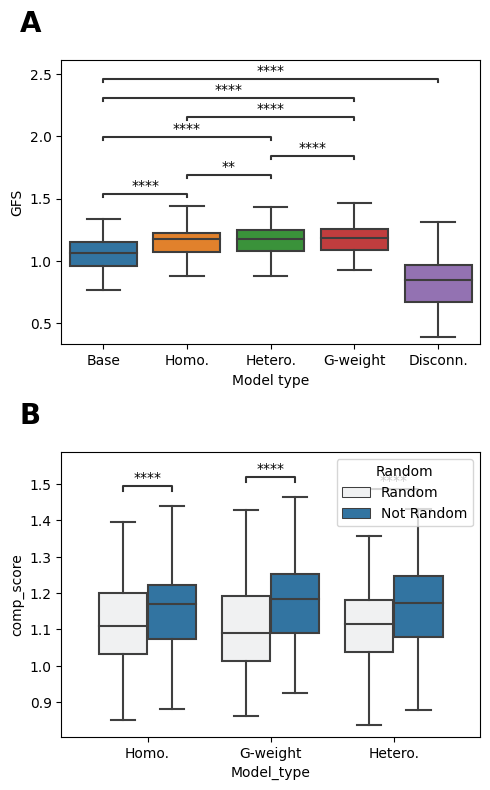

In [29]:
# Plot the boxplot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 8))
plot_obs(df_max_comp_score, "comp_score", axs[0])
axs[0].set_xlabel("Model type")
axs[0].set_ylabel("GFS")
plot_random_comparison(
    df_max_comp_score_boxplot_compare_rand, "comp_score", axs[1]
)

axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:2.425e-08 Stat=0.000e+00
Homo. vs. Hetero.: Wilcoxon test (paired samples), P_val:2.501e-01 Stat=6.570e+02
Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:7.113e-04 Stat=3.830e+02
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:1.505e-08 Stat=1.040e+02
Homo. vs. G-weight: Wilcoxon test (paired samples), P_val:1.104e-04 Stat=3.240e+02
Base vs. G-weight: Wilcoxon test (paired samples), P_val:2.207e-10 Stat=2.000e+01
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:6.664e-08 Stat=1.360e+02


/home/riccardo/anaconda3/envs/analysis/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:5.606e-06 Stat=0.000e+00
Homo. vs. Hetero.: Wilcoxon test (paired samples), P_val:8.312e-04 Stat=8.400e+01
Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:2.000e-03 Stat=9.500e+01
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:9.313e-09 Stat=5.000e+00
Homo. vs. G-weight: Wilcoxon test (paired samples), P_val:2.574e-06 Stat=3.200e+01
Base vs. G-weight: Wilcoxon test (paired samples), P_val:2.794e-09 Stat=2.000e+00
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:2.212e-06 Stat=3.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

G-weight_Random vs. G-weight_Not Random: W

/home/riccardo/anaconda3/envs/analysis/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Hetero._Random vs. Hetero._Not Random: Wilcoxon test (paired samples), P_val:1.863e-09 Stat=1.000e+00


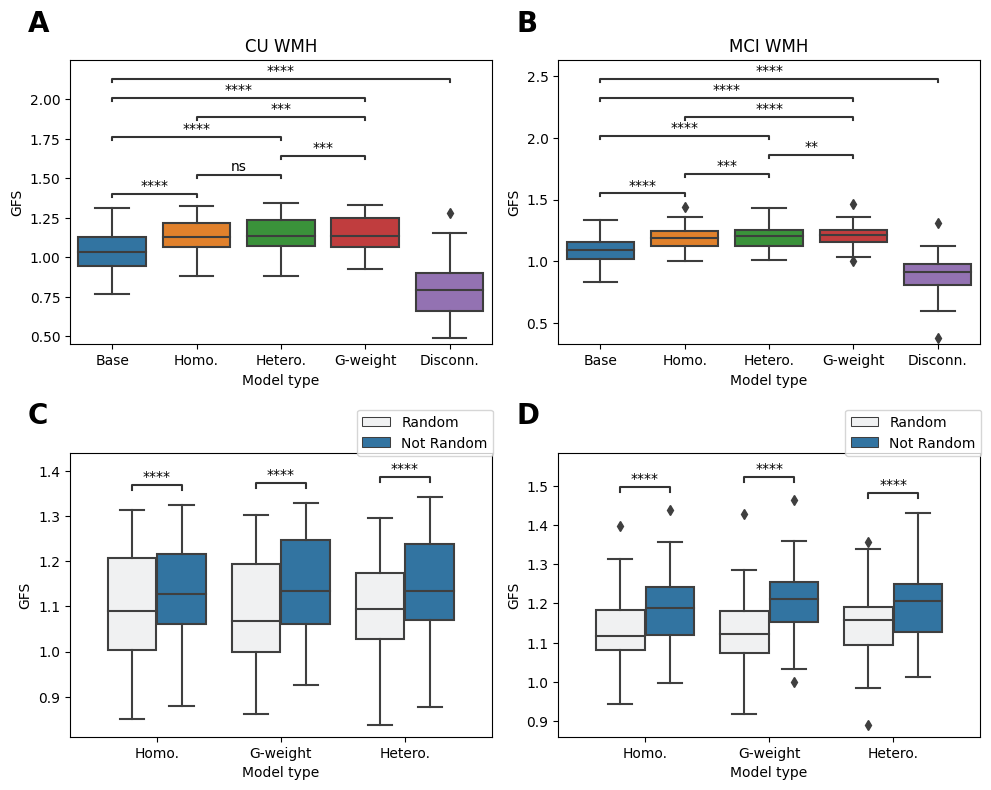

In [30]:
# Plot the boxplot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plot_obs(df_max_comp_score_CN, "comp_score", axs[0, 0])
plot_obs(df_max_comp_score_mci, "comp_score", axs[0, 1])
axs[0, 0].set_xlabel("Model type")
axs[0, 1].set_xlabel("Model type")
axs[0, 0].set_ylabel("GFS")
axs[0, 1].set_ylabel("GFS")
axs[0, 0].set_title("CU WMH")
axs[0, 1].set_title("MCI WMH")
plot_random_comparison(
    df_max_comp_score_boxplot_compare_rand_cn, "comp_score", axs[1, 0]
)
plot_random_comparison(
    df_max_comp_score_boxplot_compare_rand_mci, "comp_score", axs[1, 1]
)
axs[1, 0].set_xlabel("Model type")
axs[1, 1].set_xlabel("Model type")
axs[1, 0].set_ylabel("GFS")
axs[1, 1].set_ylabel("GFS")
axs[1, 0].legend(loc="upper right", bbox_to_anchor=(1.02, 1.175))
axs[1, 1].legend(loc="upper right", bbox_to_anchor=(1.02, 1.175))

axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Homo._CU WMH vs. Homo._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:4.861e-02 U_stat=6.450e+02
Base_CU WMH vs. Base_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:6.856e-02 U_stat=6.620e+02
Hetero._CU WMH vs. Hetero._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.378e-02 U_stat=6.280e+02
G-weight_CU WMH vs. G-weight_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.934e-02 U_stat=6.350e+02
Disconn._CU WMH vs. Disconn._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:8.474e-02 U_stat=6.730e+02


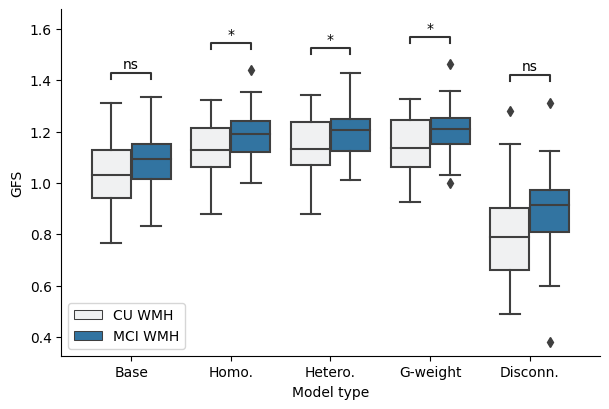

In [31]:
plot_CN_mci_comparison("comp_score", df_max_boxplot_compare)
plt.ylabel("GFS")
plt.xlabel("Model type")
plt.legend(loc="lower left")

Text(-0.1, 1.1, 'B')

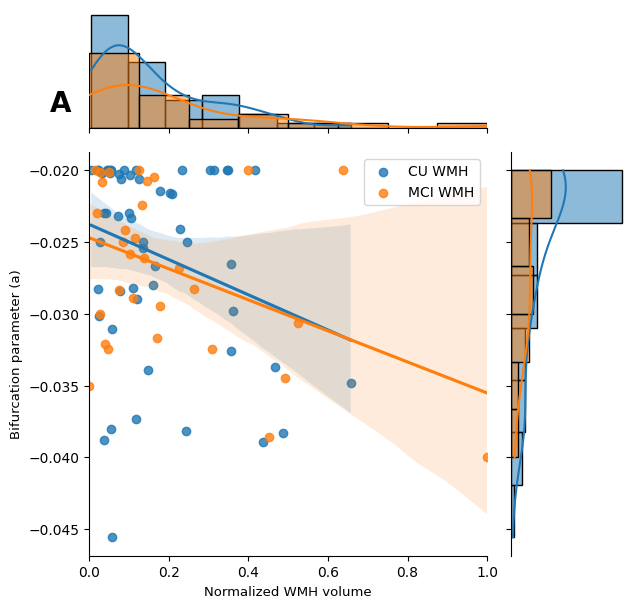

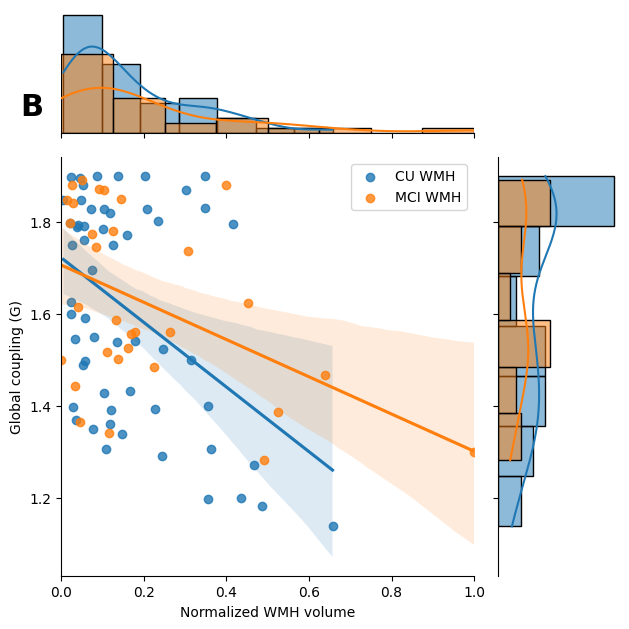

In [32]:
# Create a JointGrid for the scatter plots and histograms
grid1 = sns.JointGrid(height=6, ratio=3)

# Plot the scatter plots on the grid
sns.regplot(
    data=df_max_comp_score_a_cn, x="wmh_load", y="a", ax=grid1.ax_joint, label="CU WMH"
)
sns.regplot(
    data=df_max_comp_score_a_mci,
    x="wmh_load",
    y="a",
    ax=grid1.ax_joint,
    label="MCI WMH",
)

# Plot histograms on the top and left sides of the grid
sns.histplot(data=df_max_comp_score_a_cn, x="wmh_load", ax=grid1.ax_marg_x, kde=True)
sns.histplot(
    data=df_max_comp_score_a_mci,
    x="wmh_load",
    ax=grid1.ax_marg_x,
    kde=True,
    color="tab:orange",
)
sns.histplot(data=df_max_comp_score_a_cn, y="a", ax=grid1.ax_marg_y, kde=True)
sns.histplot(
    data=df_max_comp_score_a_mci,
    y="a",
    ax=grid1.ax_marg_y,
    kde=True,
    color="tab:orange",
)

# Set labels for the scatter plot and legends
grid1.set_axis_labels(
    "Normalized WMH volume", "Bifurcation parameter (a)", fontsize=9.5
)
grid1.ax_joint.legend()
ax1 = grid1.fig.axes[0]
ax1.text(-0.1, 1.1, "A", transform=ax1.transAxes, size=20, weight="bold")


# Create a JointGrid for the scatter plots and histograms
grid2 = sns.JointGrid(height=6.2, ratio=3)

# Plot the scatter plots on the grid
sns.regplot(
    data=df_max_comp_score_G_cn, x="wmh_load", y="G", ax=grid2.ax_joint, label="CU WMH"
)
sns.regplot(
    data=df_max_comp_score_G_mci,
    x="wmh_load",
    y="G",
    ax=grid2.ax_joint,
    label="MCI WMH",
)

# Plot histograms on the top and left sides of the grid
sns.histplot(data=df_max_comp_score_G_cn, x="wmh_load", ax=grid2.ax_marg_x, kde=True)
sns.histplot(
    data=df_max_comp_score_G_mci,
    x="wmh_load",
    ax=grid2.ax_marg_x,
    kde=True,
    color="tab:orange",
)
sns.histplot(data=df_max_comp_score_G_cn, y="G", ax=grid2.ax_marg_y, kde=True)
sns.histplot(
    data=df_max_comp_score_G_mci,
    y="G",
    ax=grid2.ax_marg_y,
    kde=True,
    color="tab:orange",
)

# Set labels for the scatter plot and legends
grid2.set_axis_labels("Normalized WMH volume", "Global coupling (G)", fontsize=10)
grid2.ax_joint.legend()
ax2 = grid2.fig.axes[0]
ax2.text(-0.1, 1.1, "B", transform=ax2.transAxes, size=22, weight="bold")

Text(-0.1, 1.1, 'B')

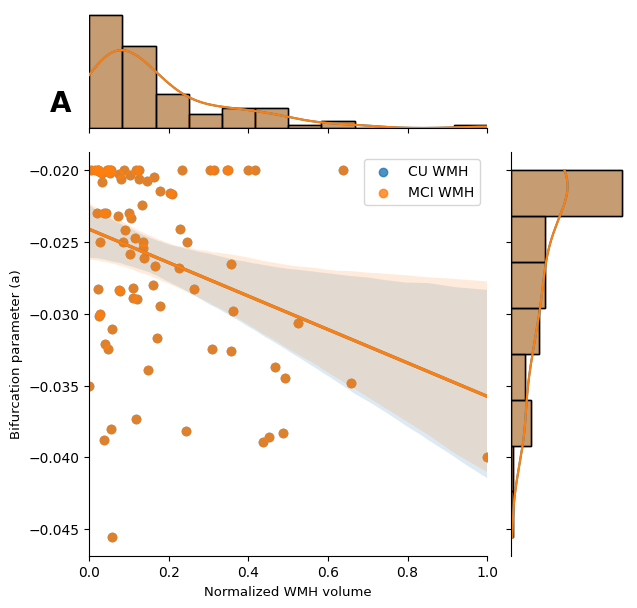

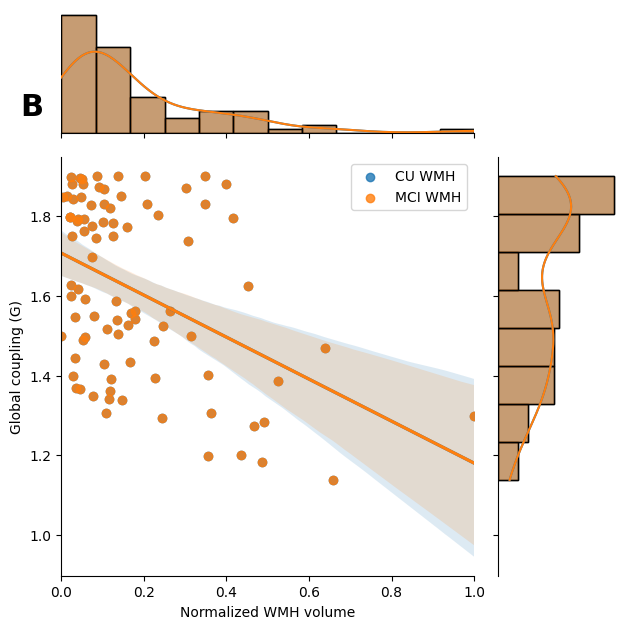

In [33]:
# Create a JointGrid for the scatter plots and histograms
grid1 = sns.JointGrid(height=6, ratio=3)

# Plot the scatter plots on the grid
sns.regplot(
    data=df_max_comp_score_a, x="wmh_load", y="a", ax=grid1.ax_joint, label="CU WMH"
)
sns.regplot(
    data=df_max_comp_score_a,
    x="wmh_load",
    y="a",
    ax=grid1.ax_joint,
    label="MCI WMH",
)

# Plot histograms on the top and left sides of the grid
sns.histplot(data=df_max_comp_score_a, x="wmh_load", ax=grid1.ax_marg_x, kde=True)
sns.histplot(
    data=df_max_comp_score_a,
    x="wmh_load",
    ax=grid1.ax_marg_x,
    kde=True,
    color="tab:orange",
)
sns.histplot(data=df_max_comp_score_a, y="a", ax=grid1.ax_marg_y, kde=True)
sns.histplot(
    data=df_max_comp_score_a,
    y="a",
    ax=grid1.ax_marg_y,
    kde=True,
    color="tab:orange",
)

# Set labels for the scatter plot and legends
grid1.set_axis_labels(
    "Normalized WMH volume", "Bifurcation parameter (a)", fontsize=9.5
)
grid1.ax_joint.legend()
ax1 = grid1.fig.axes[0]
ax1.text(-0.1, 1.1, "A", transform=ax1.transAxes, size=20, weight="bold")


# Create a JointGrid for the scatter plots and histograms
grid2 = sns.JointGrid(height=6.2, ratio=3)

# Plot the scatter plots on the grid
sns.regplot(
    data=df_max_comp_score_G, x="wmh_load", y="G", ax=grid2.ax_joint, label="CU WMH"
)
sns.regplot(
    data=df_max_comp_score_G,
    x="wmh_load",
    y="G",
    ax=grid2.ax_joint,
    label="MCI WMH",
)

# Plot histograms on the top and left sides of the grid
sns.histplot(data=df_max_comp_score_G, x="wmh_load", ax=grid2.ax_marg_x, kde=True)
sns.histplot(
    data=df_max_comp_score_G,
    x="wmh_load",
    ax=grid2.ax_marg_x,
    kde=True,
    color="tab:orange",
)
sns.histplot(data=df_max_comp_score_G, y="G", ax=grid2.ax_marg_y, kde=True)
sns.histplot(
    data=df_max_comp_score_G,
    y="G",
    ax=grid2.ax_marg_y,
    kde=True,
    color="tab:orange",
)

# Set labels for the scatter plot and legends
grid2.set_axis_labels("Normalized WMH volume", "Global coupling (G)", fontsize=10)
grid2.ax_joint.legend()
ax2 = grid2.fig.axes[0]
ax2.text(-0.1, 1.1, "B", transform=ax2.transAxes, size=22, weight="bold")

## Supplementary

### Supplementary Tables

In [34]:
from itertools import combinations

def results_combo(df, all_pairs, rand=False):
    # Create a dictionary to store the results
    results = {}
    # Loop through the pairs and perform wilcoxon test to see if model performance is different among all possible pairs
    for pair in all_pairs:
        group1 = df[df["Model_type"] == pair[0]]
        group2 = df[df["Model_type"] == pair[1]]
        # Note: Reported as Wilcoxon T test since Scipy.stats.wilcoxon() method reports the T value and not the W value
        t_statistic_comp_score, p_value_comp_score = stats.wilcoxon(
            group1["comp_score"], group2["comp_score"]
        )
        # Save everything in a results dictionary
        results[f"{pair[0]} vs {pair[1]}"] = {
            "t_statistic_comp_score": t_statistic_comp_score,
            "p_value_comp_score": p_value_comp_score,
        }

    return results

# Use itertools.combinations to create a combination of all model types (same for CN and MCI)
model_pairs = list(combinations(df_max_comp_score_CN["Model_type"].unique(), 2))

# Perform all the comparisons both for CU with WMH and for MCI with WMH for non-random vs. baseline and vs. one another...
results_pairs_cn = results_combo(df_max_comp_score_CN, model_pairs, rand=False)
results_pairs_mci = results_combo(df_max_comp_score_mci, model_pairs, rand=False)
# Store everythin in dataframes
df_results_pairs_cn = pd.DataFrame().from_dict(results_pairs_cn).T
df_results_pairs_mci = pd.DataFrame().from_dict(results_pairs_mci).T

# Now we create a summary dataset with quartiles and median for the different observables for CU WMH
df_describe_model_fit_cn_wmh = round(
    df_max_comp_score_CN.groupby("Model_type").describe()[
        [
            ("comp_score", "25%"),
            ("comp_score", "50%"),
            ("comp_score", "75%"),
        ]
    ],
    3,
)
# ... and for MCI WMH
df_describe_model_fit_mci_wmh = round(
    df_max_comp_score_mci.groupby("Model_type").describe()[
        [
            ("comp_score", "25%"),
            ("comp_score", "50%"),
            ("comp_score", "75%"),
        ]
    ],
    3,
)

# This is just to create a subIndex with the group name for better visualization
df_describe_model_fit_cn_wmh_nicer = pd.concat(
    {"CU with WMH": df_describe_model_fit_cn_wmh}, names=["Group"]
)
df_describe_model_fit_mci_wmh_nicer = pd.concat(
    {"MCI with WMH": df_describe_model_fit_mci_wmh}, names=["Group"]
)
df_describe_model_fit_together = pd.concat(
    [df_describe_model_fit_cn_wmh_nicer, df_describe_model_fit_mci_wmh_nicer]
)

# Here we are going to summarise in just one column median (IQR) for all observables...
df_describe_model_fit_together[("GFS", "Median (IQR)")] = (
    df_describe_model_fit_together[("comp_score", "50%")].astype(str)
    + " ("
    + df_describe_model_fit_together[("comp_score", "25%")].astype(str)
    + "-"
    + df_describe_model_fit_together[("comp_score", "75%")].astype(str)
    + ")"
)

# ... and we get rid of previous columns, as they are now redundant
df_describe_model_fit_final= df_describe_model_fit_together.iloc[:, -1:]

# Now we want to add to the table all the p-values of the comparisons between model fits that were previously calculated
# It is a bit tedious now, as I set them one by one, probably there is a faster way?
# We populate the table twice with the same numbers (col, row) and (row, col), but I feel it's more understandable
# compared to just leaving a lot of empty cells...
# We also change the names of the columns, to be in line with the observables described in the paper
list_obs = [("p-value GFS", "p_value_comp_score"),
            ]

# For different group we need to feed from the specific group dataset
group_dfs = [("CU with WMH", df_results_pairs_cn),
            ("MCI with WMH", df_results_pairs_mci),]

for obs in list_obs:
    # We first create empty columns
    df_describe_model_fit_final[(obs[0], "vs. Base")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. Disconn.")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. G-weight")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. Hetero.")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. Homo.")] = np.nan

    for df in group_dfs:
        df_describe_model_fit_final.loc[
            [(df[0], "Disconn.")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs Hetero.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs Homo.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. Disconn.")]
        ] = df[1].loc["Base vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["Base vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Base vs Hetero.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Base vs Homo.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Disconn.")]
        ] = df[1].loc["G-weight vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. Disconn.")]
        ] = df[1].loc["Hetero. vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. Disconn.")]
        ] = df[1].loc["Homo. vs Disconn.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Disconn.")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["G-weight vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Disconn.")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Hetero. vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Disconn.")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Homo. vs Disconn.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["Hetero. vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["Homo. vs G-weight", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Hetero. vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Homo. vs G-weight", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Homo. vs Hetero.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Homo. vs Hetero.", obs[1]]


# Better formatting
all_cols = df_describe_model_fit_final.columns.to_list()
num = df_describe_model_fit_final._get_numeric_data()
num_cols = num.columns.to_list()
non_num_cols = [col for col in all_cols if col not in num_cols]
num[num.astype(float) < 0.001] = "< 0.001"
df_newly_formatted = pd.concat([num, df_describe_model_fit_final[non_num_cols]], axis = 1)
new_cols = df_newly_formatted.columns.to_list()
new_cols_ordered = new_cols[-1:] + new_cols[:-1]
suppl_table1 = df_newly_formatted[new_cols_ordered]
suppl_table1.to_csv(RES_DIR / "table_compare_all_models.csv")
suppl_table1

/home/riccardo/anaconda3/envs/analysis/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/tmp/ipykernel_2250/3685179464.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_describe_model_fit_final[(obs[0], "vs. Base")] = np.nan
/tmp/ipykernel_2250/3685179464.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_de

GFS p-value GFS               \
                                Median (IQR)    vs. Base vs. Disconn.   
Group        Model_type                                                 
CU with WMH  Base        1.031 (0.944-1.128)         NaN      < 0.001   
             Disconn.     0.79 (0.661-0.902)     < 0.001          NaN   
             G-weight    1.135 (1.061-1.246)     < 0.001      < 0.001   
             Hetero.     1.133 (1.071-1.238)     < 0.001      < 0.001   
             Homo.       1.127 (1.062-1.216)     < 0.001      < 0.001   
MCI with WMH Base        1.093 (1.014-1.153)         NaN      < 0.001   
             Disconn.    0.913 (0.809-0.974)     < 0.001          NaN   
             G-weight    1.211 (1.153-1.253)     < 0.001      < 0.001   
             Hetero.     1.206 (1.126-1.249)     < 0.001      < 0.001   
             Homo.       1.189 (1.119-1.241)     < 0.001      < 0.001   

                                                            
                        vs. G-weight vs. Hetero. vs. Homo.  
Group        Model_type                                     
CU with WMH  Base            < 0.001     < 0.001   < 0.001  
             Disconn.        < 0.001     < 0.001   < 0.001  
             G-weight            NaN     < 0.001   < 0.001  
             Hetero.         < 0.001         NaN  0.250083  
             Homo.           < 0.001    0.250083       NaN  
MCI with WMH Base            < 0.001     < 0.001   < 0.001  
             Disconn.        < 0.001     < 0.001   < 0.001  
             G-weight            NaN       0.002   < 0.001  
             Hetero.           0.002         NaN   < 0.001  
             Homo.           < 0.001     < 0.001       NaN

In [35]:
print("The best (b, w) for CN subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_fit_b_CN_a, best_fit_w_CN_a}")
print(f"Homogeneous G-weighted model: {best_fit_b_CN_G, best_fit_w_CN_G}")
print(f"Heterogeneous a-weighted model: {best_fit_b_CN_het, best_fit_w_CN_het}")
print("######################################################################")
print("The best b and w for MCI subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_fit_b_mci_a, best_fit_w_mci_a}")
print(f"Homogeneous G-weighted model: {best_fit_b_mci_G, best_fit_w_mci_G}")
print(f"Heterogeneous a-weighted model: {best_fit_b_mci_het, best_fit_w_mci_het}")

dict_summary_best_w_b = {
    "": ["b", "w", "b", "w"],
    "Homogeneous a-weighted": [
        f"{best_fit_b_CN_a}",
        f"{best_fit_w_CN_a}",
        f"{best_fit_b_mci_a}",
        f"{best_fit_w_mci_a}",
    ],
    "G-weighted model": [
        f"{best_fit_b_CN_G}",
        f"{best_fit_w_CN_G}",
        f"{best_fit_b_mci_G}",
        f"{best_fit_w_mci_G}",
    ],
    "Heterogeneous a-weighted model": [
        f"{best_fit_b_CN_het}",
        f"{best_fit_w_CN_het}",
        f"{best_fit_b_mci_het}",
        f"{best_fit_w_mci_het}",
    ],
}
df_summary_best_w_b = pd.DataFrame.from_dict(dict_summary_best_w_b).T
df_summary_best_w_b.columns = ["CU WMH", "", "MCI WMH", ""]
#df_summary_best_w_b.to_csv(RES_DIR / "suppl_table2_best_b_w_group_level.csv")
df_summary_best_w_b

The best (b, w) for CN subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.008)
Homogeneous G-weighted model: (0.0, -0.65)
Heterogeneous a-weighted model: (-0.005, 0.0)
######################################################################
The best b and w for MCI subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.013)
Homogeneous G-weighted model: (-0.1, -0.35)
Heterogeneous a-weighted model: (0.0, -0.018)


,CU WMH,,MCI WMH,
,b,w,b,w
Homogeneous a-weighted,0.0,-0.008,0.0,-0.013
G-weighted model,0.0,-0.65,-0.1,-0.35
Heterogeneous a-weighted model,-0.005,0.0,0.0,-0.018


### Supplementary Figures

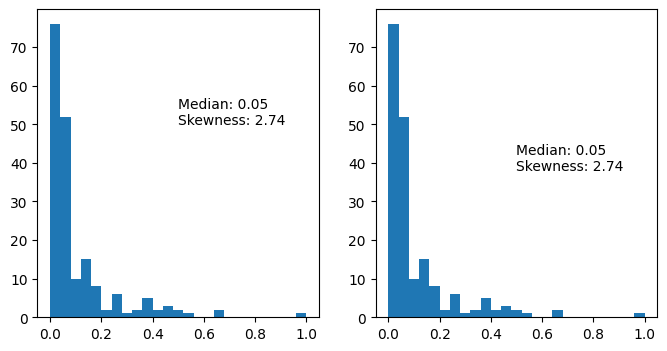

In [36]:
wmh_pre = (
    df_petTOAD_pre["WMH_load_subj_space"] - df_petTOAD_pre["WMH_load_subj_space"].min()
) / (
    df_petTOAD_pre["WMH_load_subj_space"].max()
    - df_petTOAD_pre["WMH_load_subj_space"].min()
)
wmh_post = (
    df_petTOAD["WMH_load_subj_space"] - df_petTOAD["WMH_load_subj_space"].min()
) / (df_petTOAD["WMH_load_subj_space"].max() - df_petTOAD["WMH_load_subj_space"].min())
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(wmh_pre, bins=25)
plt.annotate(
    f"Median: {round(wmh_pre.median(), 2)}\nSkewness: {round(stats.skew(wmh_pre), 2)}",
    (0.5, 50),
)
plt.subplot(122)
plt.hist(wmh_post, bins=25)
plt.annotate(
    f"Median: {round(wmh_post.median(), 2)}\nSkewness: {round(stats.skew(wmh_post), 2)}",
    (0.5, 38),
)
plt.savefig(FIG_DIR / "distribution_pre_post_normalized_WMH.png")

CU WMH: r^2, pval for MMSE and a: 0.068 , 0.051
CU WMH: r^2, pval for PTEDUCAT and a: 0.073 , 0.044
CU WMH: r^2, pval for MMSE and G: 0.09 , 0.02452
CU WMH: r^2, pval for PTEDUCAT and G: 0.017 , 0.336
MCI WMH: r^2, pval for MMSE and a: 0.002 , 1
MCI WMH: r^2, pval for PTEDUCAT and a: 0.034 , 0.323
MCI WMH: r^2, pval for MMSE and G: 0.0 , 0.906
MCI WMH: r^2, pval for PTEDUCAT and G: 0.003 , 0.76


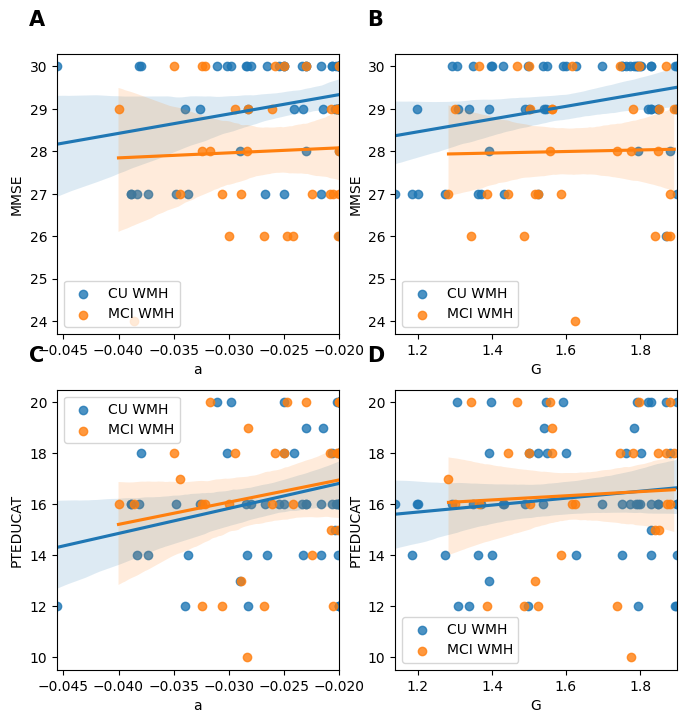

In [37]:
def lin_reg(df, x, y):
    # Use statsmodels to calculate p-values for the coefficients
    X_with_intercept = sm.add_constant(
        df[x]
    )  # Add a constant (intercept) term to the features
    model = sm.OLS(
        df[y], X_with_intercept
    ).fit()  # Fit an OLS (ordinary least squares) model
    # Get the coefficients (w) and intercept (b)
    w = model.params[x]
    b = model.params["const"]
    r2 = model.rsquared
    p = model.pvalues[x]

    return w, b, r2, p


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
sns.regplot(
    x="a", y="MMSE", data=df_max_comp_score_a_cn_mmse, label="CU WMH", ax=axs[0, 0]
)
sns.regplot(
    x="a", y="MMSE", data=df_max_comp_score_a_mci_mmse, label="MCI WMH", ax=axs[0, 0]
)
sns.regplot(
    x="G", y="MMSE", data=df_max_comp_score_G_cn_mmse, label="CU WMH", ax=axs[0, 1]
)
sns.regplot(
    x="G", y="MMSE", data=df_max_comp_score_G_mci_mmse, label="MCI WMH", ax=axs[0, 1]
)

sns.regplot(
    x="a", y="PTEDUCAT", data=df_max_comp_score_a_cn_mmse, label="CU WMH", ax=axs[1, 0]
)
sns.regplot(
    x="a",
    y="PTEDUCAT",
    data=df_max_comp_score_a_mci_mmse,
    label="MCI WMH",
    ax=axs[1, 0],
)
sns.regplot(
    x="G", y="PTEDUCAT", data=df_max_comp_score_G_cn_mmse, label="CU WMH", ax=axs[1, 1]
)
sns.regplot(
    x="G",
    y="PTEDUCAT",
    data=df_max_comp_score_G_mci_mmse,
    label="MCI WMH",
    ax=axs[1, 1],
)
axs[0, 0].legend(loc="lower left")
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=15,
        weight="bold",
    )
#plt.savefig(RES_DIR / "supplementary_a_G_MMSE_PTEDUCAT_rel.png")


_, _, r2_a_cn_mmse, p_a_cn_mmse = lin_reg(df_max_comp_score_a_cn_mmse, "a", "MMSE")
_, _, r2_a_mci_mmse, p_a_mci_mmse = lin_reg(df_max_comp_score_a_mci_mmse, "a", "MMSE")
_, _, r2_a_cn_pteducat, p_a_cn_pteducat = lin_reg(
    df_max_comp_score_a_cn_mmse, "a", "PTEDUCAT"
)
_, _, r2_a_mci_pteducat, p_a_mci_pteducat = lin_reg(
    df_max_comp_score_a_mci_mmse, "a", "PTEDUCAT"
)

_, _, r2_G_cn_mmse, p_G_cn_mmse = lin_reg(df_max_comp_score_G_cn_mmse, "G", "MMSE")
_, _, r2_G_mci_mmse, p_G_mci_mmse = lin_reg(df_max_comp_score_G_mci_mmse, "G", "MMSE")
_, _, r2_G_cn_pteducat, p_G_cn_pteducat = lin_reg(
    df_max_comp_score_G_cn_mmse, "G", "PTEDUCAT"
)
_, _, r2_G_mci_pteducat, p_G_mci_pteducat = lin_reg(
    df_max_comp_score_G_mci_mmse, "G", "PTEDUCAT"
)

print(
    "CU WMH: r^2, pval for MMSE and a:",
    round(r2_a_cn_mmse, 3),
    ",",
    round(p_a_cn_mmse, 3),
)
print(
    "CU WMH: r^2, pval for PTEDUCAT and a:",
    round(r2_a_cn_pteducat, 3),
    ",",
    round(p_a_cn_pteducat, 3),
)
print(
    "CU WMH: r^2, pval for MMSE and G:",
    round(r2_G_cn_mmse, 3),
    ",",
    round(p_G_cn_mmse, 5),
)
print(
    "CU WMH: r^2, pval for PTEDUCAT and G:",
    round(r2_G_cn_pteducat, 3),
    ",",
    round(p_G_cn_pteducat, 3),
)

print(
    "MCI WMH: r^2, pval for MMSE and a:",
    round(r2_a_mci_mmse, 3),
    ",",
    round(p_a_mci_mmse),
)
print(
    "MCI WMH: r^2, pval for PTEDUCAT and a:",
    round(r2_a_mci_pteducat, 3),
    ",",
    round(p_a_mci_pteducat, 3),
)
print(
    "MCI WMH: r^2, pval for MMSE and G:",
    round(r2_G_mci_mmse, 3),
    ",",
    round(p_G_mci_mmse, 3),
)
print(
    "MCI WMH: r^2, pval for PTEDUCAT and G:",
    round(r2_G_mci_pteducat, 3),
    ",",
    round(p_G_mci_pteducat, 3),
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:3.655e-02 Stat=1.420e+03
Homo. vs. Hetero.: Wilcoxon test (paired samples), P_val:9.764e-01 Stat=1.907e+03
Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:2.657e-01 Stat=1.651e+03
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:5.568e-03 Stat=1.259e+03
Homo. vs. G-weight: Wilcoxon test (paired samples), P_val:3.118e-01 Stat=1.675e+03
Base vs. G-weight: Wilcoxon test (paired samples), P_val:2.091e-03 Stat=1.187e+03
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:7.058e-12 Stat=2.940e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero._Random vs. Hetero._Not Random: Wil

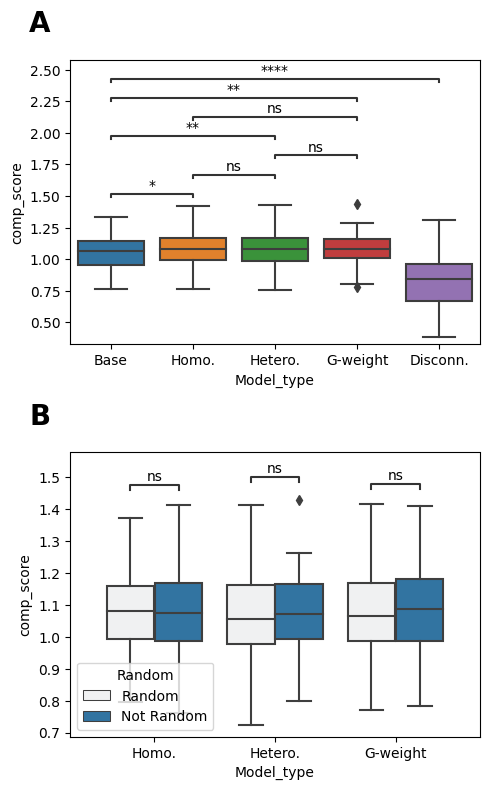

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
plot_obs(df_boxplot_compare, "comp_score", axs[0])
plot_random_comparison(df_boxplot_compare_rand, "comp_score", axs[1])
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:2.305e-01 Stat=6.510e+02
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:1.488e-01 Stat=6.210e+02
Base vs. G-weight: Wilcoxon test (paired samples), P_val:5.629e-02 Stat=5.640e+02
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:6.664e-08 Stat=1.360e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:1.353e-01 Stat=1.710e+02
Homo. vs. Hetero.: Wilcoxon test (paired samples), P_val:5.682e-01 Stat=2.180e+02
Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:7.793e-01 Stat=2.330e+02
Base vs. Hetero.: Wilcoxon test (paired 

/home/riccardo/anaconda3/envs/analysis/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero._Random vs. Hetero._Not Random: Wilcoxon test (paired samples), P_val:9.027e-02 Stat=1.610e+02
Homo._Random vs. Homo._Not Random: Wilcoxon test (paired samples), P_val:2.549e-01 Stat=1.530e+02
G-weight_Random vs. G-weight_Not Random: Wilcoxon test (paired samples), P_val:2.465e-02 Stat=1.340e+02


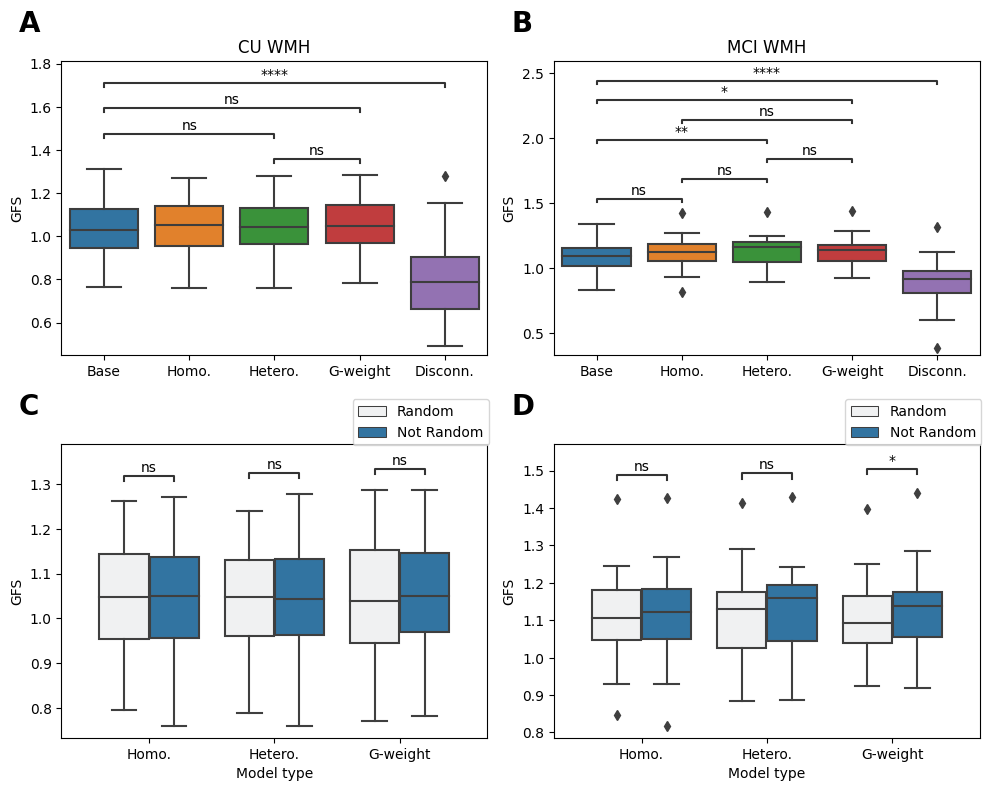

In [39]:
# Plot the boxplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
plot_obs(df_boxplot_compare_CN, "comp_score", axs[0, 0], eq=True)
plot_obs(df_boxplot_compare_mci, "comp_score", axs[0, 1])
axs[0, 0].set_xlabel("")
axs[0, 1].set_xlabel("")
axs[0, 0].set_ylabel("GFS")
axs[0, 1].set_ylabel("GFS")
axs[0, 0].set_title("CU WMH")
axs[0, 1].set_title("MCI WMH")
plot_random_comparison(df_boxplot_compare_rand_cn, "comp_score", axs[1, 0])
plot_random_comparison(df_boxplot_compare_rand_mci, "comp_score", axs[1, 1])
axs[1, 0].set_xlabel("Model type")
axs[1, 1].set_xlabel("Model type")
axs[1, 0].set_ylabel("GFS")
axs[1, 1].set_ylabel("GFS")
axs[1, 0].legend(loc="upper right", bbox_to_anchor=(1.02, 1.175))
axs[1, 1].legend(loc="upper right", bbox_to_anchor=(1.02, 1.175))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )
fig.tight_layout()
#plt.savefig(RES_DIR / "boxplot_group_level_simulations.png")

In [ ]:
# Testing the model with w and b derived from the linear regressions above
df_a_glob_big = pd.DataFrame()
df_G_glob_big = pd.DataFrame()

# We loop through every subject
for subj in subjs_to_sim:
    # we read the csv of saved results for each subject for all models
    df_a_glob = pd.read_csv(
        GLOB_A_DIR / f"sub-{subj}_df_results_homogeneous_a-weight.csv", index_col=0
    )

    df_G_glob = pd.read_csv(
        GLOB_G_DIR / f"sub-{subj}_df_results_homogeneous_G-weight.csv", index_col=0
    )

    # Set the PTID column == to this subject
    df_a_glob["PTID"] = subj
    df_G_glob["PTID"] = subj

    # we concatenate results of all subjects and create model-specific datasets with all patients
    df_a_glob_big = pd.concat([df_a_glob_big, df_a_glob], ignore_index=True)
    df_G_glob_big = pd.concat([df_G_glob_big, df_G_glob], ignore_index=True)

# Then, we convert phfcd to 1-phfcd so to have higher numbers = better fits
df_a_glob_big["phfcd_ks"] = 1 - df_a_glob_big["phfcd_ks"]
df_G_glob_big["phfcd_ks"] = 1 - df_G_glob_big["phfcd_ks"]
df_a_glob_big["comp_score"] = df_a_glob_big["fc_pearson"] + 1 * df_a_glob_big["phfcd_ks"]
df_G_glob_big["comp_score"] = df_G_glob_big["fc_pearson"] + 1 * df_G_glob_big["phfcd_ks"]
df_a_glob_big["Model_type"] = "Homo."
df_G_glob_big["Model_type"] = "G-weight"
df_glob_no_G = pd.concat([df_a_glob_big, df_base_merged])
df_glob = pd.concat([df_glob_no_G, df_G_glob_big])
df_glob_cn_wmh = df_glob[df_glob["PTID"].isin(CN_WMH)]
df_glob_mci_wmh = df_glob[df_glob["PTID"].isin(MCI_WMH)]

order = ["Base", "Homo.", "G-weight"]
# Choose the combinations that you want to test..
pairs = [
    ("Base", "Homo."),
    ("Base", "G-weight"),
    #("Homo.", "G-weight"),
]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8, 4))
f = sns.boxplot(data=df_glob_cn_wmh, x="Model_type", y="comp_score", ax=axs[0], order = order)
annotator = Annotator(f, pairs, data=df_glob_cn_wmh, x="Model_type", y="comp_score", order=order)
# Choose the type of statistical test to perform
annotator.configure(test="Wilcoxon", text_format="star", loc="inside", verbose=1)
annotator.apply_and_annotate()
axs[0].set_xlabel("Model Type")
axs[0].set_ylabel("GFS")
axs[0].set_title("CU WMH")
g = sns.boxplot(data=df_glob_mci_wmh, x="Model_type", y="comp_score", ax=axs[1], order = order)
annotator = Annotator(g, pairs, data=df_glob_mci_wmh, x="Model_type", y="comp_score", order=order)
# Choose the type of statistical test to perform
annotator.configure(test="Wilcoxon", text_format="star", loc="inside", verbose=1)
annotator.apply_and_annotate()
axs[1].set_xlabel("Model Type")
axs[1].set_ylabel("GFS")
axs[1].set_title("MCI WMH")
fig.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: '/home/riccardo/petTOAD/results/final_simulations_log_more_detailed/homogeneous_a_global_model/sub-ADNI002S6053_df_results_homogeneous_a-weight.csv'

## Other old code

In [ ]:
# # Plot the model performance between groups
# fig = plt.figure(figsize=(6, 4))
# plot_CN_mci_comparison("comp_score", df_boxplot_compare)
# plt.xlabel("Model type")
# plt.ylabel("GFS")
# plt.legend()
# plt.savefig(FIG_DIR / "Figure4.png")

In [ ]:
# # Plot a histogram depicting how the distributions of a and G vary between groups
# list_a_homo_cn = []
# list_G_cn = []
# list_a_het_cn = []
# list_wmh_cn = []

# list_a_homo_mci = []
# list_G_mci = []
# list_a_het_mci = []
# list_wmh_mci = []

# for subj in subjs_to_sim:
#     wmh = wmh_dict[subj]
#     # node_damage = get_node_damage_ext(subj)

#     if subj in CN_WMH:
#         list_wmh_cn.append(wmh)
#         a_homo = -0.02 + best_fit_w_CN_a * wmh + best_fit_b_CN_a
#         G = 2.0 + best_fit_w_CN_G * wmh + best_fit_b_CN_G
#         # a_het = np.array([round(-0.02 + best_fit_w_CN_het*(1-n) + best_fit_b_CN_het, 5) for n in node_damage])
#         list_a_homo_cn.append(a_homo)
#         list_G_cn.append(G)
#         # list_a_het_cn.append(a_het)

#     elif subj in MCI_WMH:
#         list_wmh_mci.append(wmh)
#         a_homo = -0.02 + best_fit_w_mci_a * wmh + best_fit_b_mci_a
#         G = 2.0 + best_fit_w_mci_G * wmh + best_fit_b_mci_G
#         # a_het = np.array([round(-0.02 + best_fit_w_mci_het*(1-n) + best_fit_b_mci_het, 5) for n in node_damage])
#         list_a_homo_mci.append(a_homo)
#         list_G_mci.append(G)
#         # list_a_het_mci.append(a_het)


# print(f"The min. value of a for CU with WMH is {round(min(list_a_homo_cn), 3)}")
# print(f"The max. value of a for CU with WMH is {round(max(list_a_homo_cn), 3)}")
# # print(f"The min. value of a heterogeneous for CU with WMH is {round(min([min(node) for node in list_a_het_cn]), 3)}")
# # print(f"The max. value of a heterogeneous for CU with WMH is {round(max([max(node) for node in list_a_het_cn]), 3)}")
# print(f"The min. value of G for CU with WMH is {round(min(list_G_cn), 3)}")
# print(f"The max. value of G for CU with WMH is {round(max(list_G_cn), 3)}")

# print(
#     f"The min. value of a homogeneous for MCI with WMH is {round(min(list_a_homo_mci), 3)}"
# )
# print(
#     f"The max. value of a homogeneous for MCI with WMH is {round(max(list_a_homo_mci), 3)}"
# )
# # print(f"The min. value of a heterogeneous for MCI with WMH is {round(min([min(node) for node in list_a_het_mci]), 3)}")
# # print(f"The max. value of a heterogeneous for MCI with WMH is {round(max([max(node) for node in list_a_het_mci]), 3)}")
# print(f"The min. value of G for MCI with WMH is {round(min(list_G_mci), 3)}")
# print(f"The max. value of G for MCI with WMH is {round(max(list_G_mci), 3)}")

In [ ]:
# # plot how the histplot changes
# fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# # plt.hist(list_a_homo_cn, weights=np.ones_like(list_a_homo_cn) / len(list_a_homo_cn), alpha = 0.4, label = "CU WMH");
# axs[0, 0].hist(
#     list_a_homo_mci,
#     weights=np.ones_like(list_a_homo_mci) / len(list_a_homo_mci),
#     alpha=0.4,
#     bins=15,
#     label="MCI WMH",
# )

# axs[0, 0].set_ylabel("Frequency")
# axs[0, 0].set_xlabel(r"$a$")
# axs[0, 0].set_xlim(-0.041, -0.015)
# axs[0, 0].axvline(x=-0.02, color="orange", lw=2, linestyle=":", label="CU no WMH")
# axs[0, 0].arrow(
#     -0.02,
#     0.25,
#     -0.005,
#     0,
#     length_includes_head=False,
#     width=0.01,
#     head_length=0.002,
#     head_width=0.015,
#     fill=False,
#     linestyle="-",
#     lw=0.8,
#     edgecolor="black",
# )

# axs[0, 1].hist(
#     list_G_mci,
#     weights=np.ones_like(list_G_mci) / len(list_G_mci),
#     alpha=0.4,
#     bins=15,
#     label="MCI WMH",
# )
# axs[0, 1].set_xlabel(r"$G$")
# axs[0, 1].set_ylabel("Frequency")
# axs[0, 1].set_xlim(0.9, 2.1)
# axs[0, 1].axvline(x=2.0, color="orange", lw=2, linestyle=":", label="CU WMH")
# axs[0, 1].arrow(
#     2,
#     0.25,
#     -0.25,
#     0,
#     length_includes_head=False,
#     width=0.01,
#     head_length=0.1,
#     head_width=0.015,
#     fill=False,
#     linestyle="-",
#     lw=0.8,
#     edgecolor="black",
# )

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:6.886e-01 Stat=1.498e+03
Homo. vs. Hetero.: Wilcoxon test (paired samples), P_val:9.883e-01 Stat=1.577e+03
Hetero. vs. G-weight: Wilcoxon test (paired samples), P_val:5.808e-01 Stat=1.467e+03
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:5.000e-01 Stat=1.442e+03
Homo. vs. G-weight: Wilcoxon test (paired samples), P_val:2.331e-01 Stat=1.336e+03
Base vs. G-weight: Wilcoxon test (paired samples), P_val:2.508e-01 Stat=1.345e+03
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:4.614e-11 Stat=2.330e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samp

Text(0.5, 0.98, 'MCI WMH')

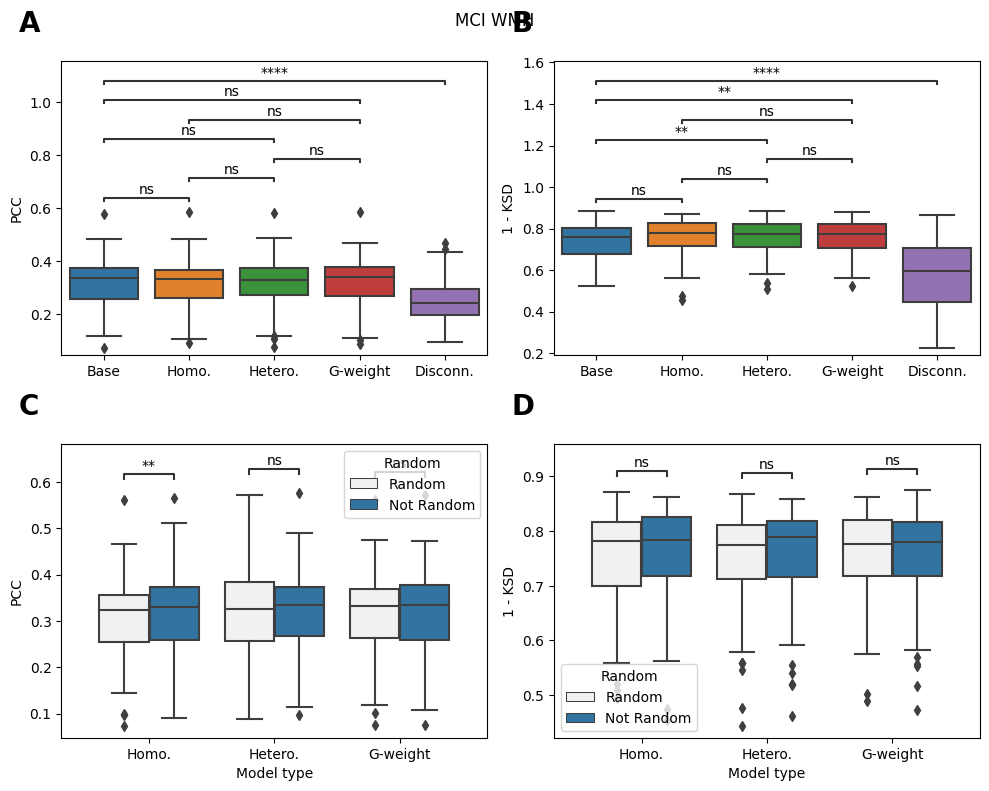

In [ ]:
# PCC and 1 - KSD in MCI WMH
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
plot_obs(df_boxplot_compare, "fc_pearson", axs[0, 0])
plot_obs(df_boxplot_compare, "phfcd_ks", axs[0, 1])
plot_random_comparison(df_boxplot_compare_rand, "fc_pearson", axs[1, 0])
plot_random_comparison(df_boxplot_compare_rand, "phfcd_ks", axs[1, 1])

axs[0, 0].set_xlabel("")
axs[0, 1].set_xlabel("")
axs[0, 0].set_ylabel("PCC")
axs[0, 1].set_ylabel("1 - KSD")
axs[1, 0].set_xlabel("Model type")
axs[1, 1].set_xlabel("Model type")
axs[1, 0].set_ylabel("PCC")
axs[1, 1].set_ylabel("1 - KSD")
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )
fig.tight_layout()
fig.suptitle("MCI WMH")

In [ ]:
# #If you want / need to do also PCC and 1-phFCD comparison us plt.subplot() and change the function to also accept axis

# plot_CN_mci_comparison("fc_pearson", axs[0])
# axs[0].set_ylabel("PCC")
# axs[0].set_xlabel("Model Type")
# axs[0].legend(["CU WMH", "MCI WMH"])
# leg0 = axs[0].get_legend()
# leg0.legendHandles[1].set_color('C0')
# leg0.legendHandles[1].set_edgecolor('k')
# plot_CN_mci_comparison("phfcd_ks", axs[1])
# axs[1].set_ylabel("1 - KSD")
# axs[1].set_xlabel("Model Type")
# axs[1].legend(["CU WMH", "MCI WMH"])
# leg1 = axs[1].get_legend()
# leg1.legend_handles[1].set_color('C0')
# leg1.legend_handles[1].set_edgecolor('k')
# plot_CN_mci_comparison("comp_score", axs[2])
# axs[2].set_ylabel("GFS")
# axs[2].set_xlabel("Model Type")
# axs[2].legend(["CU WMH", "MCI WMH"])
# leg2 = axs[2].get_legend()
# leg2.legend_handles[1].set_color('C0')
# leg2.legend_handles[1].set_edgecolor('k')
# fig.tight_layout()

In [ ]:
# # PCC and 1 - KSD in CU WMH
# fig, axs = plt.subplots(2, 2, figsize=(20, 16))
# plot_obs(df_boxplot_compare_CN, "fc_pearson", axs[0, 0])
# plot_obs(df_boxplot_compare_CN, "phfcd_ks", axs[0, 1])
# plot_random_comparison(df_boxplot_compare_rand_cn, "fc_pearson", axs[1, 0])
# plot_random_comparison(df_boxplot_compare_rand_cn, "phfcd_ks", axs[1, 1])

# axs[0, 0].set_xlabel("")
# axs[0, 1].set_xlabel("")
# axs[0, 0].set_ylabel("PCC")
# axs[0, 1].set_ylabel("1 - KSD")
# axs[1, 0].set_xlabel("Model type")
# axs[1, 1].set_xlabel("Model type")
# axs[1, 0].set_ylabel("PCC")
# axs[1, 1].set_ylabel("1 - KSD")
# axs = axs.flat

# for n, ax in enumerate(axs):
#     ax.text(
#         -0.1,
#         1.1,
#         string.ascii_uppercase[n],
#         transform=ax.transAxes,
#         size=20,
#         weight="bold",
#     )
# fig.tight_layout()